# SM_London - Modeling

In [7]:
#Important Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from pandas.tseries.offsets import DateOffset
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from sklearn.metrics import mean_absolute_error

%matplotlib inline

### Importing Data

In [2]:
acornmodel_df = pd.read_csv('/Users/nicolasrosal/Desktop/Machine Learning Projects/SM_London/Dataset after EDA/acornmodel_df.csv')

energymodel_df = pd.read_csv('/Users/nicolasrosal/Desktop/Machine Learning Projects/SM_London/Dataset after EDA/energymodel_df.csv').set_index('day')


In [3]:
print('Acorn DataFrame Head:\n\n', acornmodel_df.head(), '\n\n')
print('Energy DataFrame Head:\n\n', energymodel_df.head(), '\n\n')

Acorn DataFrame Head:

      Acorn         day  Avg.Dawn  Avg.Morning_Afternoon  Avg.Evening  \
0  ACORN-A  2012-10-13  0.133556               0.266667       0.2927   
1  ACORN-A  2012-10-13  0.227889               0.342667       0.3197   
2  ACORN-A  2012-10-13  1.216778               2.424250       2.7396   
3  ACORN-E  2012-10-13  0.294333               0.552583       0.7322   
4  ACORN-A  2012-10-13  0.126000               0.521250       0.6157   

   Avg.Night  ohe_StartSpr/EndAut  ohe_Summer  ohe_Winter  energy_sum  
0   0.218854                    1           0           0   11.087000  
1   0.552292                    1           0           0   19.283000  
2   1.344580                    1           0           0   89.343999  
3   0.366943                    1           0           0   22.727000  
4   0.335382                    1           0           0   19.271000   


Energy DataFrame Head:

             Avg.Dawn  Avg.Morning_Afternoon  Avg.Evening  Avg.Night  \
day         

In [4]:
print('Acorn DataFrame Columns:\n\n', acornmodel_df.columns, '\n\n')
print('Energy DataFrame Columns:\n\n', energymodel_df.columns, '\n\n')

Acorn DataFrame Columns:

 Index(['Acorn', 'day', 'Avg.Dawn', 'Avg.Morning_Afternoon', 'Avg.Evening',
       'Avg.Night', 'ohe_StartSpr/EndAut', 'ohe_Summer', 'ohe_Winter',
       'energy_sum'],
      dtype='object') 


Energy DataFrame Columns:

 Index(['Avg.Dawn', 'Avg.Morning_Afternoon', 'Avg.Evening', 'Avg.Night',
       'ohe_StartSpr/EndAut', 'ohe_Summer', 'ohe_Winter', 'energy_sum'],
      dtype='object') 




In [5]:
print('Acorn DataFrame Data Types:\n\n', acornmodel_df.dtypes, '\n\n')
print('Energy DataFrame Data Types:\n\n', energymodel_df.dtypes, '\n\n')

Acorn DataFrame Data Types:

 Acorn                     object
day                       object
Avg.Dawn                 float64
Avg.Morning_Afternoon    float64
Avg.Evening              float64
Avg.Night                float64
ohe_StartSpr/EndAut        int64
ohe_Summer                 int64
ohe_Winter                 int64
energy_sum               float64
dtype: object 


Energy DataFrame Data Types:

 Avg.Dawn                 float64
Avg.Morning_Afternoon    float64
Avg.Evening              float64
Avg.Night                float64
ohe_StartSpr/EndAut      float64
ohe_Summer               float64
ohe_Winter               float64
energy_sum               float64
dtype: object 




In [6]:
#Changing data type of column 'day' in Acorn dataset
acornmodel_df['day'] = pd.to_datetime(acornmodel_df['day'])

### Preparing Data for Modeling

In [8]:
#function to create test and train set
def train_test(dataframe, border):
    '''
    Splits time-series dataframe into train and test sets. Index has to be of datetime data type. 
    '''
    
    return dataframe.loc[:border], dataframe.loc[border:]

In [9]:
def scaler(train_df, test_df):
    '''
    
    '''
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train = scaler.fit_transform(train_df).flatten()
    scaled_test = scaler.transform(test_df).flatten()
    
    return scaler, scaled_train, scaled_test

In [10]:
#function to create timeseries X and y (COPY)
def create_timeseries(sequence, timestepsx, timestepsy = 0, n_features = 1):
    
    '''
    
    '''
    
    X, Y = [], []
    
    if timestepsy != 0: 
        for i in range(len(sequence)):
            #Define end of input and output sequences
            inp_end_idx = i + timestepsx
            out_end_idx = inp_end_idx + timestepsy
        
            #Break if end of output sequence is out of the sequence length
            if out_end_idx > len(sequence):
                break
        
            #Create seq_x and seq_y
            seq_x = sequence[i:(inp_end_idx)]
            X.append(seq_x)
            seq_y = sequence[(inp_end_idx): (out_end_idx)]
            Y.append(seq_y)
                        
    else:
        for i in range(len(sequence) - timestepsx + 1):
            inp_end_idx = i + timestepsx
            seq_x = sequence[i:(inp_end_idx)]
            X.append(seq_x)
            
    
    X = np.array(X)
    X = X.reshape((X.shape[0], timestepsx, n_features))
    Y = np.array(Y)
        
    return X, Y
        
#####ADAPTED FROM: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

     Preparing energymodel_df

In [11]:
#Train test split
energytrain_df, energytest_df = train_test(energymodel_df, '2013-09-27')

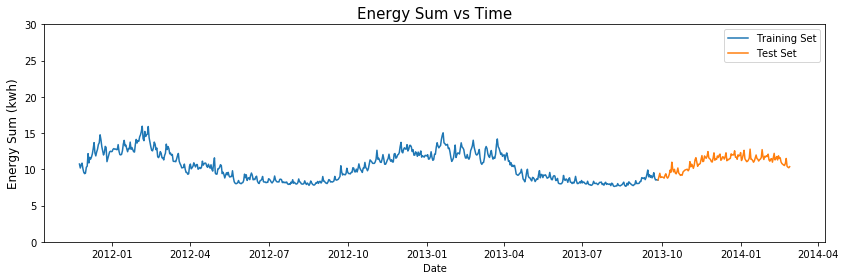

In [12]:
#Visualise Train and Test
plt.figure(figsize=(14,4))

plt.plot(pd.to_datetime(energytrain_df.index), energytrain_df['energy_sum'])
plt.plot(pd.to_datetime(energytest_df.index), energytest_df['energy_sum'])

plt.title("Energy Sum vs Time", fontsize = 15)
plt.ylabel("Energy Sum (kwh)", fontsize = 12)
plt.xlabel("Date")
plt.legend(["Training Set", "Test Set"])
plt.ylim(0, 30, 2)

plt.show()

In [13]:
#Scaling Data

scaler_energy, scaled_energytrain, scaled_energytest = scaler(energytrain_df[['energy_sum']], energytest_df[['energy_sum']])

In [14]:
#Creating X_train, y_train, X_test, y_test (FOR TREND)
Xtrend_energytrain, ytrend_energytrain = create_timeseries(scaled_energytrain, 30, 1)
ytrend_energytrain = ytrend_energytrain.flatten()
Xtrend_energytest, ytrend_energytest = create_timeseries(scaled_energytest, 30, 1)
ytrend_energytest = ytrend_energytest.flatten()

In [15]:
#Verifying Shapes
print(Xtrend_energytrain.shape)
print(ytrend_energytrain.shape)
print(Xtrend_energytest.shape)
print(ytrend_energytest.shape)

(643, 30, 1)
(643,)
(123, 30, 1)
(123,)


In [16]:
#Creating X_train, y_train, X_test, y_test (FOR FORECASTING)
Xfore_energytrain, yfore_energytrain = create_timeseries(scaled_energytrain, 30, 30)
yfore_energytrain = yfore_energytrain.reshape(yfore_energytrain.shape[0], 30, 1)
Xfore_energytest, yfore_energytest = create_timeseries(scaled_energytest, 30, 30)
yfore_energytest = yfore_energytest.reshape(yfore_energytest.shape[0], 30, 1)

In [17]:
#Verifying Shapes
print(Xfore_energytrain.shape)
print(yfore_energytrain.shape)
print(Xfore_energytest.shape)
print(yfore_energytest.shape)

(614, 30, 1)
(614, 30, 1)
(94, 30, 1)
(94, 30, 1)


     Preparing acornmodel_df

In [18]:
#List of unique Acorns
ids = list(acornmodel_df['Acorn'].unique())

#create dictionary with each LCLid as keys and its data as the value
df_ = {}
for i in ids:
    df_[i] = acornmodel_df[acornmodel_df['Acorn'] == i].drop('Acorn', axis = 1).set_index('day').sort_values('day')
    df_[i] = df_[i].groupby('day').median()[['energy_sum']]

In [19]:
#Finding date that allows us to standarise time windows
for i in ids:
    print(df_[i].shape)
    print("Start date is", min(df_[i].index.date))
    print("End date is", max(df_[i].index.date))

(815, 1)
Start date is 2011-12-04
End date is 2014-02-27
(825, 1)
Start date is 2011-11-24
End date is 2014-02-27
(795, 1)
Start date is 2011-12-24
End date is 2014-02-27
(812, 1)
Start date is 2011-12-07
End date is 2014-02-27
(825, 1)
Start date is 2011-11-24
End date is 2014-02-27
(825, 1)
Start date is 2011-11-24
End date is 2014-02-27
(825, 1)
Start date is 2011-11-24
End date is 2014-02-27
(824, 1)
Start date is 2011-11-25
End date is 2014-02-27
(764, 1)
Start date is 2012-01-24
End date is 2014-02-27
(811, 1)
Start date is 2011-12-08
End date is 2014-02-27
(820, 1)
Start date is 2011-11-29
End date is 2014-02-27
(825, 1)
Start date is 2011-11-24
End date is 2014-02-27
(804, 1)
Start date is 2011-12-15
End date is 2014-02-27
(810, 1)
Start date is 2011-12-09
End date is 2014-02-27
(823, 1)
Start date is 2011-11-26
End date is 2014-02-27
(811, 1)
Start date is 2011-12-08
End date is 2014-02-27
(825, 1)
Start date is 2011-11-24
End date is 2014-02-27
(811, 1)
Start date is 2011-12-

In [20]:
#Standarising time window for each acorn (latest start was '2012-01-24')
for i in ids:
    df_[i] = df_[i]['2012-01-24':]

In [21]:
#Veryfing standarisation
for i in ids:
    print(df_[i]['2012-01-24':].shape)

(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)
(764, 1)


In [22]:
#Creating Train and Test sets
df_new = {}
for i in ids:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = train_test(df_[i], "2013-09-27")

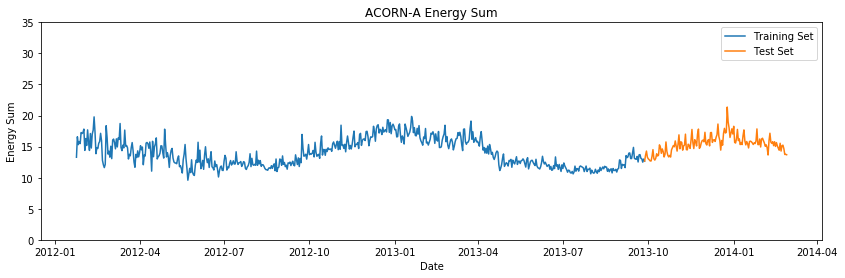

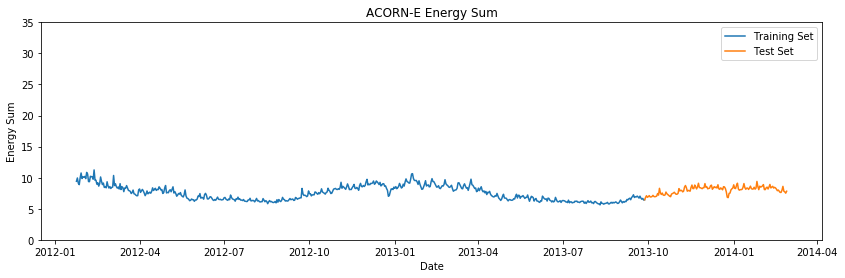

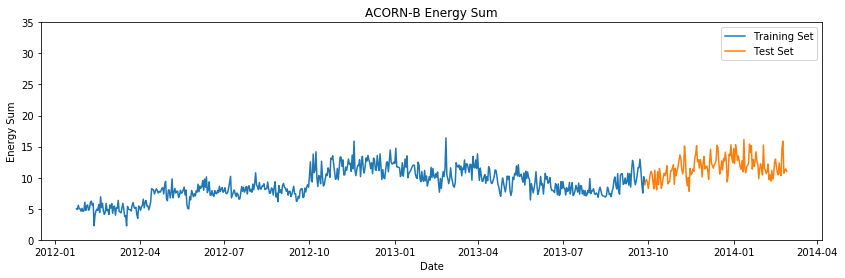

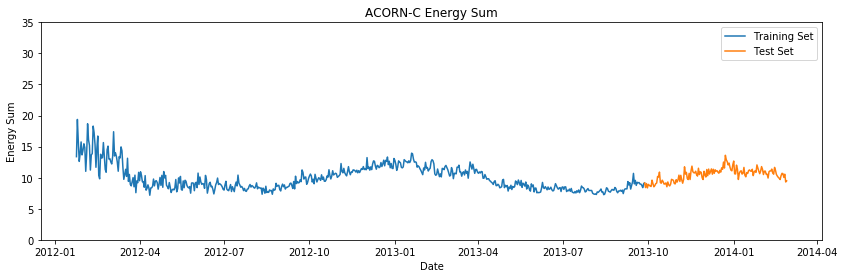

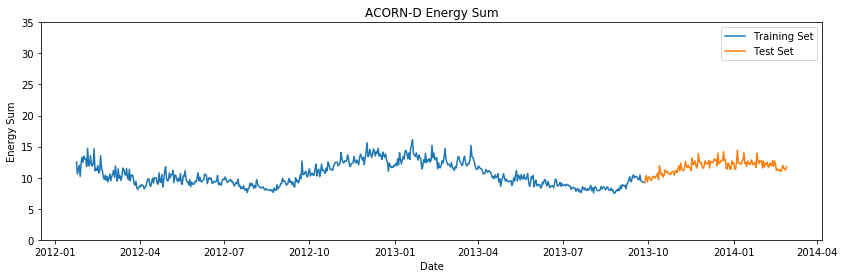

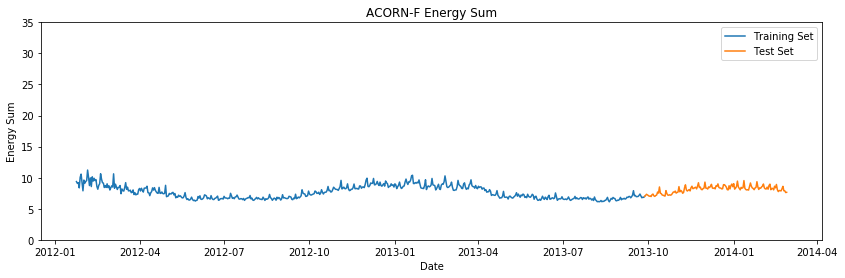

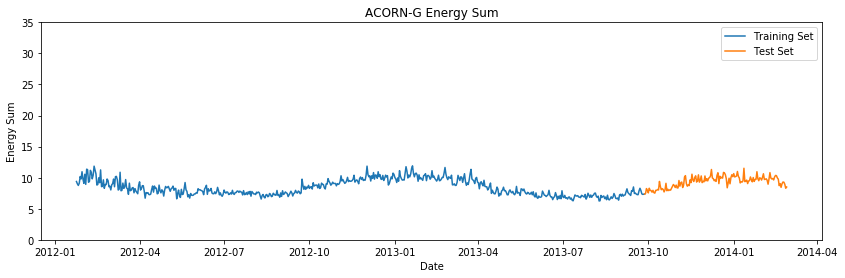

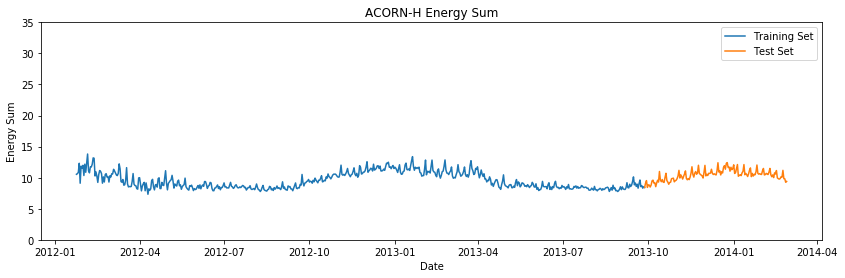

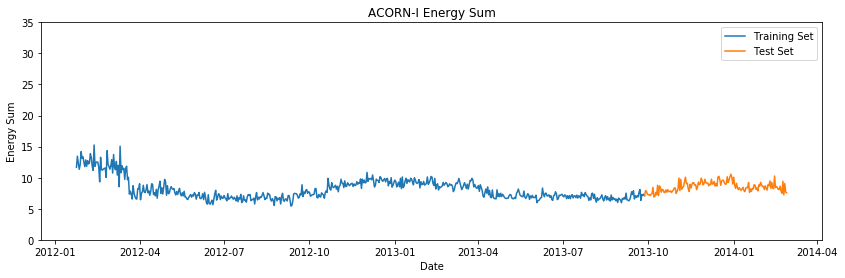

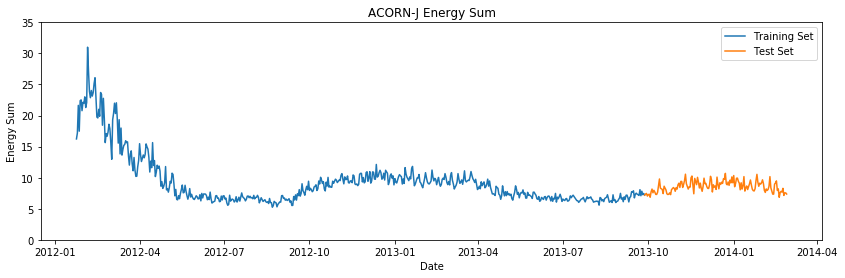

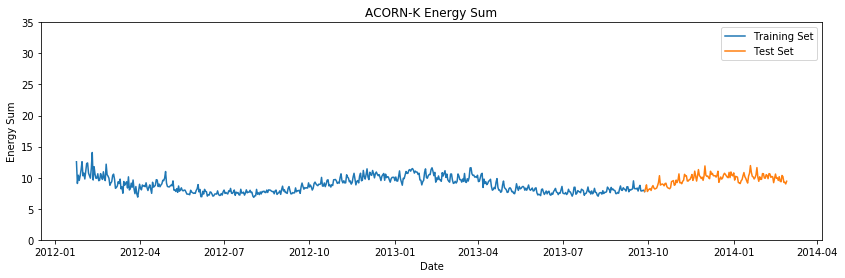

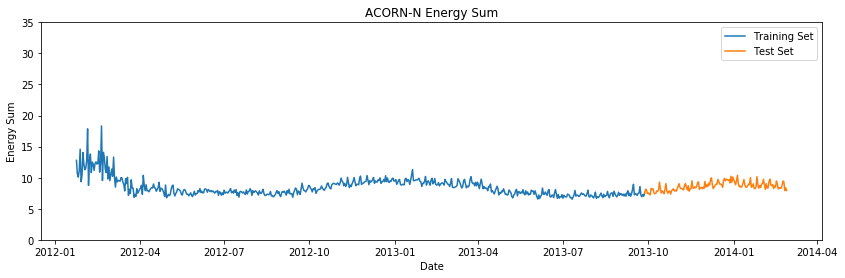

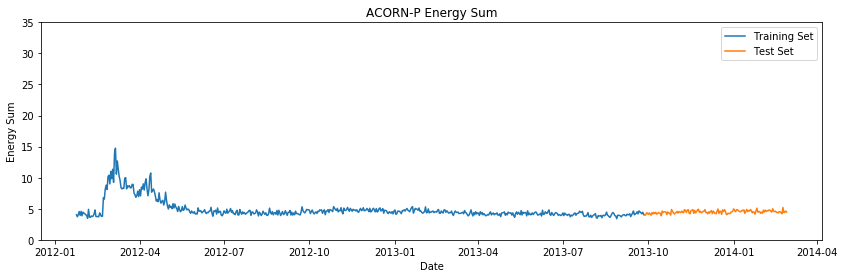

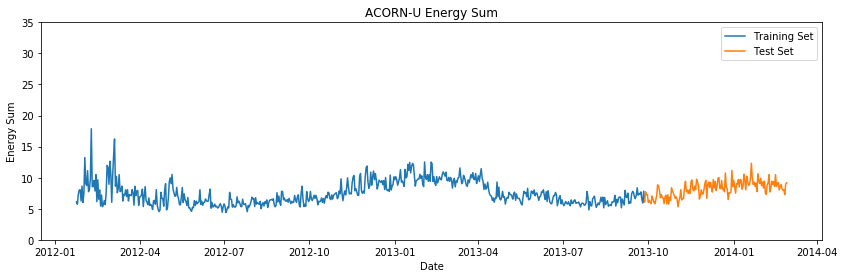

In [23]:
#Plotting Splits (Using 'energy_sum')
for i in ids:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Energy Sum")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.ylim(0, 35, 2)
    plt.title(i + " Energy Sum")

In [24]:
#Scaling Data
df_scaled = {}

for i in ids: 
    df_scaled[i] = {}
    df_scaled[i]['Scaler'], df_scaled[i]["Train"], df_scaled[i]["Test"] = scaler(df_new[i]["Train"], 
                                                                                 df_new[i]["Test"])

In [25]:
#Creating X_train, y_train, X_test, y_test (FOR FORECASTING)
df_trend = {}

for i in ids:
    df_trend[i] = {}
    df_trend[i]["XTrain"], df_trend[i]["yTrain"] = create_timeseries(df_scaled[i]["Train"], 30,1 )
    df_trend[i]["yTrain"] = df_trend[i]["yTrain"].flatten()
    df_trend[i]["XTest"], df_trend[i]["yTest"] = create_timeseries(df_scaled[i]["Test"], 30, 1)
    df_trend[i]["yTest"] = df_trend[i]["yTest"].flatten()

In [26]:
print(df_trend['ACORN-A']["XTrain"].shape)
print(df_trend['ACORN-A']["yTrain"].shape)
print(df_trend['ACORN-A']["XTest"].shape)
print(df_trend['ACORN-A']["yTest"].shape)

(582, 30, 1)
(582,)
(123, 30, 1)
(123,)


In [27]:
#Creating X_train, y_train, X_test, y_test (FOR FORECASTING)
df_forecast = {}

for i in ids:
    df_forecast[i] = {}
    df_forecast[i]["XTrain"], df_forecast[i]["yTrain"] = create_timeseries(df_scaled[i]["Train"], 30, 30)
    df_forecast[i]["yTrain"] = df_forecast[i]["yTrain"].reshape(df_forecast[i]["yTrain"].shape[0], 30, 1)
    df_forecast[i]["XTest"], df_forecast[i]["yTest"] = create_timeseries(df_scaled[i]["Test"], 30, 30)
    df_forecast[i]["yTest"] = df_forecast[i]["yTest"].reshape(df_forecast[i]["yTest"].shape[0], 30, 1)

In [28]:
print(df_forecast['ACORN-A']["XTrain"].shape)
print(df_forecast['ACORN-A']["yTrain"].shape)
print(df_forecast['ACORN-A']["XTest"].shape)
print(df_forecast['ACORN-A']["yTest"].shape)

(553, 30, 1)
(553, 30, 1)
(94, 30, 1)
(94, 30, 1)


### Modelling

In [414]:
#Forecast n days into the future

def forecast(model_sel, forecast_data, timestepsx, n_forecast, days_forward, n_features = 1):

    '''

    '''

    pred_list = []
    train_forecast, _ = create_timeseries(forecast_data, timestepsx, n_features = n_features)
    batch = train_forecast[-1:]
    
    for i in range(n_forecast):
        pred_list.append(model_sel.predict(batch)[0][:days_forward])
        batch = np.append(batch[:,days_forward:,:], [pred_list[i]] ,axis=1)
        
    return pred_list

In [179]:
def forecast_visualization(train_df, test_df, scaler, forecast, n_forecast, days_forward):

    '''
    
    '''

    idx = n_forecast * days_forward
    
    #Creating new dates
    add_dates = [(pd.to_datetime(train_df.index)[-1] + DateOffset(days = x)).date().strftime("%Y-%m-%d") for x in range(0, idx)]
    future_dates = pd.DataFrame(index=add_dates[0:],columns=train_df.columns)
    future_dates.index = pd.to_datetime(future_dates.index)
    
    #Creating projections df
    pred_array = np.array(forecast) 
    pred_array = pred_array.reshape(pred_array.shape[0], pred_array.shape[1])
    pred_array = scaler.inverse_transform(pred_array).flatten()
    
    df_predict = pd.DataFrame(pred_array,
                              index=future_dates[-idx:].index, columns=['Prediction'])
    df_predict.index = df_predict.index.date
    test_df.index = pd.to_datetime(test_df.index).date
    df_proj = pd.concat([test_df, df_predict], axis=1)
    
    #Plotting
    plt.figure(figsize=(20, 5))
    plt.plot(pd.to_datetime(df_proj.index[:idx]), df_proj['energy_sum'][:idx])
    plt.plot(pd.to_datetime(df_proj.index), df_proj['Prediction'], color='r')
    plt.plot(pd.to_datetime(train_df.index[-idx:]), train_df['energy_sum'][-idx:], color='g')
    
    plt.show()

    return df_proj

In [407]:
def model(dataset, time_distributed = True, n_features_output = 1):
    
    '''
    
    '''

    np.random.seed(123)

    #LSTM Architecture

    model = Sequential()

    #Hidden Layer 1
    model.add(LSTM(units = 64, return_sequences = True, input_shape = (dataset.shape[1], dataset.shape[2])))

    #Dropout Layer 1
    model.add(Dropout(rate = 0.25))

    #Hidden Layer 2
    model.add(LSTM(units = 64, return_sequences = True))
    
    #Dropout Layer 2
    model.add(Dropout(rate = 0.25))

    #Hidden Layer 3
    model.add(LSTM(units = 64, return_sequences = True))

    #Dropout Layer 3
    model.add(Dropout(rate = 0.25))

    #Hidden Layer 4
    model.add(LSTM(units = 64, return_sequences = True))

    #Dropout Layer 4
    model.add(Dropout(rate = 0.25))
    
    if time_distributed:
        
        #Hidden Layer 5
        model.add(LSTM(units = 64, return_sequences = True))
        
        #Output Layer 
        model.add(TimeDistributed(Dense(n_features_output)))
        
    else: 
        #Hidden Layer 5
        model.add(LSTM(units = 64))
        
        #Output Layer 
        model.add(Dense(n_features_output))

    #Compile
    model.compile(loss = 'mean_squared_error', optimizer = 'RMSprop', metrics = ['mean_absolute_error'])

    #Summary
    print(model.summary())
    
    return model

     Forecast of Total Energy Use in London

- Trend:

In [32]:
model_trend = model(Xtrend_energytrain, time_distributed = False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 64)            16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 64)           

In [33]:
#Fit
model_trend.fit(Xtrend_energytrain, ytrend_energytrain, epochs = 100)


Epoch 1/100
643/643 [==============================] - 7s 11ms/step - loss: 0.0583 - mean_absolute_error: 0.1560
Epoch 2/100
643/643 [==============================] - 6s 9ms/step - loss: 0.0178 - mean_absolute_error: 0.1003
Epoch 3/100
643/643 [==============================] - 4s 6ms/step - loss: 0.0220 - mean_absolute_error: 0.1069
Epoch 4/100
643/643 [==============================] - 6s 10ms/step - loss: 0.0163 - mean_absolute_error: 0.0954
Epoch 5/100
643/643 [==============================] - 6s 9ms/step - loss: 0.0179 - mean_absolute_error: 0.0973
Epoch 6/100
643/643 [==============================] - 6s 9ms/step - loss: 0.0142 - mean_absolute_error: 0.0886
Epoch 7/100
643/643 [==============================] - 6s 9ms/step - loss: 0.0176 - mean_absolute_error: 0.0942
Epoch 8/100
643/643 [==============================] - 6s 10ms/step - loss: 0.0133 - mean_absolute_error: 0.0852
Epoch 9/100
643/643 [==============================] - 6s 9ms/step - loss: 0.0142 - mean_absolute_er

643/643 [==============================] - 5s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0493
Epoch 72/100
643/643 [==============================] - 6s 9ms/step - loss: 0.0042 - mean_absolute_error: 0.0480
Epoch 73/100
643/643 [==============================] - 4s 6ms/step - loss: 0.0043 - mean_absolute_error: 0.0496
Epoch 74/100
643/643 [==============================] - 5s 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0484
Epoch 75/100
643/643 [==============================] - 4s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0490
Epoch 76/100
643/643 [==============================] - 5s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0476
Epoch 77/100
643/643 [==============================] - 5s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0465
Epoch 78/100
643/643 [==============================] - 4s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0472
Epoch 79/100
643/643 [==============================] - 4s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0

In [34]:
#Plotting Loss over Epochs
plt.plot(model_trend.history.history['loss'], label='train')
plt.legend()
plt.show()

In [35]:
#Best loss and MAE
print(min(model_trend.history.history['loss']))
print(min(model_trend.history.history['mean_absolute_error']))

0.003565878308237665
0.044947326


In [36]:
#Evauating Model
print(model_trend.evaluate(Xtrend_energytest, ytrend_energytest))
energy_trend = model_trend.predict(Xtrend_energytest)
energy_trend = energy_trend.reshape(energy_trend.shape[0], energy_trend.shape[1])
energy_trend = scaler_energy.inverse_transform(energy_trend)

123/123 [==============================] - 1s 7ms/step
[0.005292620759729932, 0.059765469282865524]


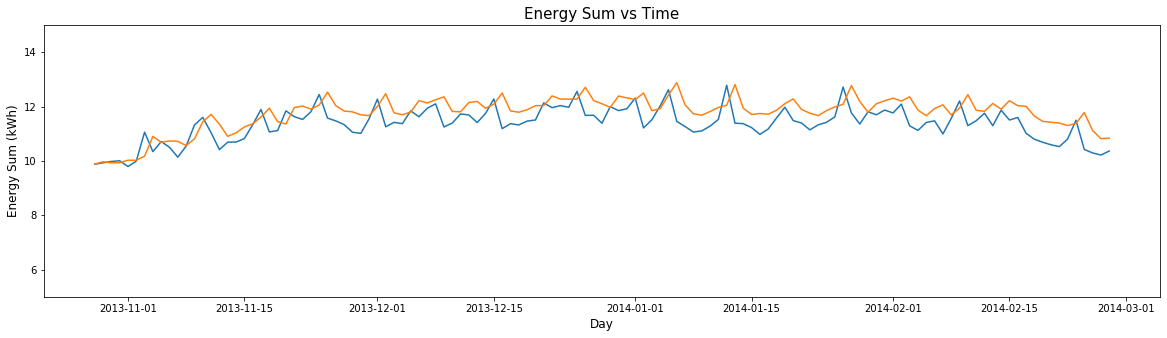

In [37]:
#Plotting results

plt.figure(figsize=(20, 5))

plt.plot(pd.to_datetime(energytest_df.index)[30:], energytest_df['energy_sum'][30:])
plt.plot(pd.to_datetime(energytest_df.index)[30:], energy_trend)
plt.title('Energy Sum vs Time', fontsize = 15)
plt.ylabel('Energy Sum (kWh)', fontsize = 12)
plt.xlabel('Day', fontsize = 12)
plt.ylim(5, 15)
  
plt.show()

In [38]:
#SCORES

# Model 1: 5 LSTM layers (64 Units) with Dropout (0.25) and one Dense Time Distributed Output. Default RMSProp optimizer.
    # MAE: 0.044947326
    # MAE Test: 0.059765469282865524

- Forecasting:

In [39]:
model_forecast = model(Xfore_energytrain)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 64)            16896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 64)           

In [43]:
#Fit
model_forecast.fit(Xfore_energytrain, yfore_energytrain, epochs = 100)

Epoch 1/100
614/614 [==============================] - 8s 12ms/step - loss: 0.0772 - mean_absolute_error: 0.2139
Epoch 2/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0505 - mean_absolute_error: 0.1814
Epoch 3/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0443 - mean_absolute_error: 0.1681
Epoch 4/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0381 - mean_absolute_error: 0.1555
Epoch 5/100
614/614 [==============================] - 4s 7ms/step - loss: 0.0347 - mean_absolute_error: 0.1475
Epoch 6/100
614/614 [==============================] - 3s 6ms/step - loss: 0.0331 - mean_absolute_error: 0.1447
Epoch 7/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0312 - mean_absolute_error: 0.1386
Epoch 8/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0310 - mean_absolute_error: 0.1406
Epoch 9/100
614/614 [==============================] - 5s 8ms/step - loss: 0.0287 - mean_absolute_error

614/614 [==============================] - 3s 5ms/step - loss: 0.0152 - mean_absolute_error: 0.0919
Epoch 74/100
614/614 [==============================] - 3s 5ms/step - loss: 0.0159 - mean_absolute_error: 0.0941
Epoch 75/100
614/614 [==============================] - 5s 8ms/step - loss: 0.0149 - mean_absolute_error: 0.0921
Epoch 76/100
614/614 [==============================] - 5s 8ms/step - loss: 0.0157 - mean_absolute_error: 0.0929
Epoch 77/100
614/614 [==============================] - 5s 8ms/step - loss: 0.0148 - mean_absolute_error: 0.0903
Epoch 78/100
614/614 [==============================] - 5s 9ms/step - loss: 0.0150 - mean_absolute_error: 0.0916
Epoch 79/100
614/614 [==============================] - 5s 8ms/step - loss: 0.0142 - mean_absolute_error: 0.0881
Epoch 80/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0149 - mean_absolute_error: 0.0903
Epoch 81/100
614/614 [==============================] - 4s 7ms/step - loss: 0.0145 - mean_absolute_error: 0.0

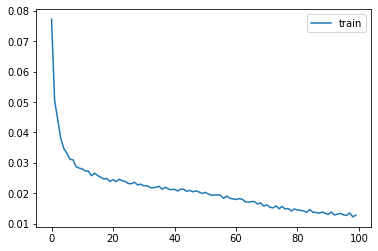

In [44]:
#Plotting Loss over Epochs
plt.plot(model_forecast.history.history['loss'], label='train')
plt.legend()
plt.show()

In [45]:
#Best loss and MAE
print(min(model_forecast.history.history['loss']))
print(min(model_forecast.history.history['mean_absolute_error']))

0.012259299050810283
0.08055499


In [46]:
#Evauating Model
print(model_forecast.evaluate(Xfore_energytest, yfore_energytest))

94/94 [==============================] - 1s 10ms/step
[0.016687306575477123, 0.10910674929618835]


In [176]:
n_forecast = 10
days_forward = 3

forecast = forecast(model_forecast, scaled_energytrain, 30, n_forecast, days_forward)

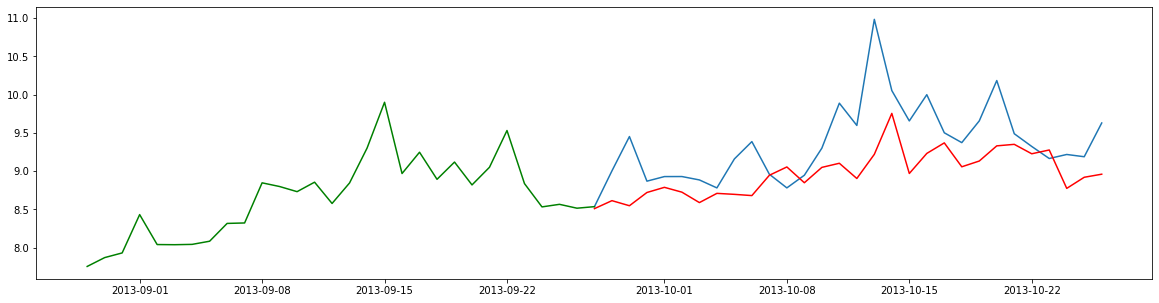

In [180]:
projections = forecast_visualization(energytrain_df, energytest_df, scaler_energy, forecast, n_forecast, days_forward)

In [184]:
mae = mean_absolute_error(projections['energy_sum'][:30], projections['Prediction'][:30])
print('mean absolute error: {}'.format(mae))

mean squared error: 0.41751142945194003


In [ ]:
##SCORES (BEST - Model 8)

# Model 1: 5 LSTM layers (64 Units) with Dropout (0.2) and one Dense Time Distributed Output. Default Adam optimizer.
    # MAE: 0.08333997
    # MAE Test: 0.11304686218500137
    # Forecast MAE: 0.5802268193028083
    
# Model 2: 5 LSTM layers (64 Units) with Dropout (0.2) and one Dense Time Distributed Output. Default RMSProp optimizer.
    # MAE: 0.07846425
    # MAE Test: 0.12108054012060165
    # Forecast MAE: 0.3877505408044281
    
# Model 3: 7 LSTM layers (30 units) with Dropout (0.2) and one Dense Time Distributed Output. Default RMSProp optimizer.
    # MAE: 0.08572971
    # MAE Test: 0.13023702800273895
    # Forecast MAE: 0.4656640349097002
    
# Model 4: 7 LSTM layers (64 units) with Dropout (0.2) and one Dense Time Distributed Output. Default RMSProp optimizer.
    # MAE: 0.074080184
    # MAE Test: 0.09017115086317062
    # Forecast MAE: 0.7606035720649361
    
# Model 5: 4 LSTM layers (128 Units) with Dropout (0.2) and one Dense Time Distributed Output. Default RMSProp optimizer.
    # MAE: 0.07212911
    # MAE Test: 0.1064617857336998
    # Forecast MAE: 0.7739044507259555
    
# Model 6: 5 LSTM layers (64 Units) with Dropout (0.2), Dense Time Distributed Output, Default RMSProp optimizer, and recurrent regularization (l2 0.01)
    # MAE: 0.107138194
    # MAE Test: 0.07936544716358185 
    # Forecast MAE: 0.3622947530741814
    
# Model 7: 5 LSTM layers (64 Units), Dense Time Distributed Output, Default RMSProp optimizer, and recurrent regularization (l2 0.01)
    # MAE: 0.106377214
    # MAE Test: 0.10191759467124939
    # Forecast MAE: 0.3826670961279176
    
# Model 8: 5 LSTM layers (64 Units) with Dropout (0.25) and one Dense Time Distributed Output. Default RMSProp optimizer.
    # MAE: 0.08055499
    # MAE Test: 0.10910674929618835
    # Forecast MAE: 0.41751142945194003
    
# Model 9: 5 LSTM layers (64 Units) with Dropout (0.15) and one Dense Time Distributed Output. Default RMSProp optimizer.
    # MAE: 0.076762415
    # MAE Test: 0.12481387704610825
    # Forecast MAE: 0.4143634185014937
    
# Model 10: 10 LSTM layers (64 Units) with Dropout (0.25) and one Dense Time Distributed Output. Default RMSProp optimizer.
    # MAE: 0.07707836
    # MAE Test: 0.09997808933258057
    # Forecast MAE: 0.5183164643372657

     Forecast of Total Energy Use per Acorn in London

- Trend:

In [188]:
#Model
acorn_trend = model(df_trend['ACORN-A']["XTrain"], time_distributed = False)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 30, 64)            16896     
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_18 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_19 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 30, 64)           

In [189]:
#Fitting
for i in ids: 
    print("Fitting to", i)
    acorn_trend.fit(df_trend[i]["XTrain"], df_trend[i]["yTrain"], epochs = 100)

Fitting to ACORN-A
Epoch 1/100
582/582 [==============================] - 9s 15ms/step - loss: 0.0825 - mean_absolute_error: 0.1883
Epoch 2/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0211 - mean_absolute_error: 0.1124
Epoch 3/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0241 - mean_absolute_error: 0.1213
Epoch 4/100
582/582 [==============================] - 4s 7ms/step - loss: 0.0276 - mean_absolute_error: 0.1271
Epoch 5/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0246 - mean_absolute_error: 0.1190
Epoch 6/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0224 - mean_absolute_error: 0.1126
Epoch 7/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0198 - mean_absolute_error: 0.1090
Epoch 8/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0215 - mean_absolute_error: 0.1102
Epoch 9/100
582/582 [==============================] - 4s 7ms/step - loss: 0.0207 - 

582/582 [==============================] - 5s 9ms/step - loss: 0.0112 - mean_absolute_error: 0.0786
Epoch 74/100
582/582 [==============================] - 5s 8ms/step - loss: 0.0116 - mean_absolute_error: 0.0793
Epoch 75/100
582/582 [==============================] - 5s 8ms/step - loss: 0.0120 - mean_absolute_error: 0.0804
Epoch 76/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0113 - mean_absolute_error: 0.0814
Epoch 77/100
582/582 [==============================] - 4s 8ms/step - loss: 0.0113 - mean_absolute_error: 0.0797
Epoch 78/100
582/582 [==============================] - 6s 11ms/step - loss: 0.0117 - mean_absolute_error: 0.0788
Epoch 79/100
582/582 [==============================] - 6s 9ms/step - loss: 0.0106 - mean_absolute_error: 0.0778
Epoch 80/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0110 - mean_absolute_error: 0.0788
Epoch 81/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0118 - mean_absolute_error: 0.

582/582 [==============================] - 4s 6ms/step - loss: 0.0042 - mean_absolute_error: 0.0479
Epoch 46/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0042 - mean_absolute_error: 0.0484
Epoch 47/100
582/582 [==============================] - 4s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0474
Epoch 48/100
582/582 [==============================] - 3s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0481
Epoch 49/100
582/582 [==============================] - 3s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0458
Epoch 50/100
582/582 [==============================] - 3s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0470
Epoch 51/100
582/582 [==============================] - 3s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0478
Epoch 52/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0038 - mean_absolute_error: 0.0456
Epoch 53/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0038 - mean_absolute_error: 0.0

582/582 [==============================] - 5s 9ms/step - loss: 0.0065 - mean_absolute_error: 0.0621
Epoch 18/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0067 - mean_absolute_error: 0.0632
Epoch 19/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0067 - mean_absolute_error: 0.0639
Epoch 20/100
582/582 [==============================] - 5s 8ms/step - loss: 0.0066 - mean_absolute_error: 0.0634
Epoch 21/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0068 - mean_absolute_error: 0.0640
Epoch 22/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0066 - mean_absolute_error: 0.0628
Epoch 23/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0067 - mean_absolute_error: 0.0629
Epoch 24/100
582/582 [==============================] - 5s 8ms/step - loss: 0.0066 - mean_absolute_error: 0.0629
Epoch 25/100
582/582 [==============================] - 5s 8ms/step - loss: 0.0065 - mean_absolute_error: 0.0

582/582 [==============================] - 6s 10ms/step - loss: 0.0056 - mean_absolute_error: 0.0573
Epoch 90/100
582/582 [==============================] - 6s 11ms/step - loss: 0.0057 - mean_absolute_error: 0.0577
Epoch 91/100
582/582 [==============================] - 7s 13ms/step - loss: 0.0053 - mean_absolute_error: 0.0556
Epoch 92/100
582/582 [==============================] - 5s 8ms/step - loss: 0.0054 - mean_absolute_error: 0.0561
Epoch 93/100
582/582 [==============================] - 6s 9ms/step - loss: 0.0055 - mean_absolute_error: 0.0575
Epoch 94/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0054 - mean_absolute_error: 0.0555
Epoch 95/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0056 - mean_absolute_error: 0.0584
Epoch 96/100
582/582 [==============================] - 3s 5ms/step - loss: 0.0053 - mean_absolute_error: 0.0556
Epoch 97/100
582/582 [==============================] - 3s 6ms/step - loss: 0.0055 - mean_absolute_error: 

582/582 [==============================] - 6s 10ms/step - loss: 0.0026 - mean_absolute_error: 0.0387
Epoch 62/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0023 - mean_absolute_error: 0.0370
Epoch 63/100
582/582 [==============================] - 6s 11ms/step - loss: 0.0022 - mean_absolute_error: 0.0365
Epoch 64/100
582/582 [==============================] - 6s 10ms/step - loss: 0.0025 - mean_absolute_error: 0.0385
Epoch 65/100
582/582 [==============================] - 6s 10ms/step - loss: 0.0024 - mean_absolute_error: 0.0379
Epoch 66/100
582/582 [==============================] - 4s 7ms/step - loss: 0.0022 - mean_absolute_error: 0.0365
Epoch 67/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0369
Epoch 68/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0025 - mean_absolute_error: 0.0385
Epoch 69/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0023 - mean_absolute_error:

582/582 [==============================] - 3s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0461
Epoch 34/100
582/582 [==============================] - 3s 5ms/step - loss: 0.0037 - mean_absolute_error: 0.0470
Epoch 35/100
582/582 [==============================] - 3s 5ms/step - loss: 0.0037 - mean_absolute_error: 0.0467
Epoch 36/100
582/582 [==============================] - 3s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0456
Epoch 37/100
582/582 [==============================] - 6s 10ms/step - loss: 0.0036 - mean_absolute_error: 0.0466
Epoch 38/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0035 - mean_absolute_error: 0.0463
Epoch 39/100
582/582 [==============================] - 5s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0453
Epoch 40/100
582/582 [==============================] - 5s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0462
Epoch 41/100
582/582 [==============================] - 5s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.

582/582 [==============================] - 5s 9ms/step - loss: 0.0038 - mean_absolute_error: 0.0459
Epoch 6/100
582/582 [==============================] - 5s 8ms/step - loss: 0.0034 - mean_absolute_error: 0.0443
Epoch 7/100
582/582 [==============================] - 7s 12ms/step - loss: 0.0034 - mean_absolute_error: 0.0455
Epoch 8/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0429
Epoch 9/100
582/582 [==============================] - 4s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0438
Epoch 10/100
582/582 [==============================] - 3s 6ms/step - loss: 0.0032 - mean_absolute_error: 0.0441
Epoch 11/100
582/582 [==============================] - 4s 7ms/step - loss: 0.0028 - mean_absolute_error: 0.0410
Epoch 12/100
582/582 [==============================] - 4s 7ms/step - loss: 0.0028 - mean_absolute_error: 0.0409
Epoch 13/100
582/582 [==============================] - 4s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0424

582/582 [==============================] - 8s 14ms/step - loss: 0.0012 - mean_absolute_error: 0.0266
Epoch 78/100
582/582 [==============================] - 8s 14ms/step - loss: 0.0012 - mean_absolute_error: 0.0272
Epoch 79/100
582/582 [==============================] - 7s 12ms/step - loss: 0.0012 - mean_absolute_error: 0.0267
Epoch 80/100
582/582 [==============================] - 6s 11ms/step - loss: 0.0011 - mean_absolute_error: 0.0256
Epoch 81/100
582/582 [==============================] - 6s 11ms/step - loss: 0.0013 - mean_absolute_error: 0.0278
Epoch 82/100
582/582 [==============================] - 7s 11ms/step - loss: 0.0011 - mean_absolute_error: 0.0260
Epoch 83/100
582/582 [==============================] - 6s 10ms/step - loss: 0.0012 - mean_absolute_error: 0.0267
Epoch 84/100
582/582 [==============================] - 5s 8ms/step - loss: 0.0011 - mean_absolute_error: 0.0254
Epoch 85/100
582/582 [==============================] - 5s 9ms/step - loss: 0.0011 - mean_absolute_err

582/582 [==============================] - 4s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0358
Epoch 50/100
582/582 [==============================] - 3s 5ms/step - loss: 0.0022 - mean_absolute_error: 0.0366
Epoch 51/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0374
Epoch 52/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0352
Epoch 53/100
582/582 [==============================] - 3s 5ms/step - loss: 0.0020 - mean_absolute_error: 0.0351
Epoch 54/100
582/582 [==============================] - 3s 6ms/step - loss: 0.0018 - mean_absolute_error: 0.0329
Epoch 55/100
582/582 [==============================] - 4s 7ms/step - loss: 0.0020 - mean_absolute_error: 0.0346
Epoch 56/100
582/582 [==============================] - 4s 6ms/step - loss: 0.0019 - mean_absolute_error: 0.0347
Epoch 57/100
582/582 [==============================] - 3s 5ms/step - loss: 0.0018 - mean_absolute_error: 0.0

582/582 [==============================] - 2s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0345A: 1s - loss: 0.0021 - mean_absolu
Epoch 21/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0356
Epoch 22/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0347
Epoch 23/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0338
Epoch 24/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0350
Epoch 25/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0328
Epoch 26/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0328
Epoch 27/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0359
Epoch 28/100
582/582 [==============================] - 2s 4ms/step - loss:

582/582 [==============================] - 2s 3ms/step - loss: 8.3882e-04 - mean_absolute_error: 0.0221
Epoch 91/100
582/582 [==============================] - 2s 3ms/step - loss: 8.5287e-04 - mean_absolute_error: 0.0232
Epoch 92/100
582/582 [==============================] - 2s 3ms/step - loss: 8.4298e-04 - mean_absolute_error: 0.0229
Epoch 93/100
582/582 [==============================] - 2s 3ms/step - loss: 7.8854e-04 - mean_absolute_error: 0.0219
Epoch 94/100
582/582 [==============================] - 2s 3ms/step - loss: 8.1729e-04 - mean_absolute_error: 0.0224
Epoch 95/100
582/582 [==============================] - 2s 3ms/step - loss: 9.3781e-04 - mean_absolute_error: 0.0235
Epoch 96/100
582/582 [==============================] - 2s 3ms/step - loss: 7.8792e-04 - mean_absolute_error: 0.0215
Epoch 97/100
582/582 [==============================] - 2s 3ms/step - loss: 9.0669e-04 - mean_absolute_error: 0.0230
Epoch 98/100
582/582 [==============================] - 2s 3ms/step - loss: 7

582/582 [==============================] - 2s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0276
Epoch 63/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0262
Epoch 64/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0261
Epoch 65/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0277
Epoch 66/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0012 - mean_absolute_error: 0.0265
Epoch 67/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0010 - mean_absolute_error: 0.0248
Epoch 68/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0258
Epoch 69/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0010 - mean_absolute_error: 0.0255
Epoch 70/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0

582/582 [==============================] - 2s 3ms/step - loss: 4.4322e-04 - mean_absolute_error: 0.0167
Epoch 33/100
582/582 [==============================] - 2s 3ms/step - loss: 4.8315e-04 - mean_absolute_error: 0.0170
Epoch 34/100
582/582 [==============================] - 2s 3ms/step - loss: 4.1356e-04 - mean_absolute_error: 0.0161
Epoch 35/100
582/582 [==============================] - 2s 3ms/step - loss: 4.0373e-04 - mean_absolute_error: 0.0159
Epoch 36/100
582/582 [==============================] - 2s 3ms/step - loss: 4.4428e-04 - mean_absolute_error: 0.0164
Epoch 37/100
582/582 [==============================] - 2s 3ms/step - loss: 4.4116e-04 - mean_absolute_error: 0.0166
Epoch 38/100
582/582 [==============================] - 2s 3ms/step - loss: 4.0184e-04 - mean_absolute_error: 0.0161
Epoch 39/100
582/582 [==============================] - 2s 3ms/step - loss: 4.7174e-04 - mean_absolute_error: 0.0168
Epoch 40/100
582/582 [==============================] - 2s 3ms/step - loss: 3

582/582 [==============================] - 2s 3ms/step - loss: 2.4693e-04 - mean_absolute_error: 0.0125
Fitting to ACORN-K
Epoch 1/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0643
Epoch 2/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0566
Epoch 3/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0046 - mean_absolute_error: 0.0536
Epoch 4/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0041 - mean_absolute_error: 0.0491
Epoch 5/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0039 - mean_absolute_error: 0.0469
Epoch 6/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0037 - mean_absolute_error: 0.0461
Epoch 7/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0033 - mean_absolute_error: 0.0436
Epoch 8/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0034 - mean_abso

582/582 [==============================] - 2s 3ms/step - loss: 7.7181e-04 - mean_absolute_error: 0.0216A: 0s - loss: 7.7510e-04 - mean_absolute_erro
Epoch 72/100
582/582 [==============================] - 2s 3ms/step - loss: 7.4897e-04 - mean_absolute_error: 0.0209
Epoch 73/100
582/582 [==============================] - 2s 3ms/step - loss: 7.2817e-04 - mean_absolute_error: 0.0212
Epoch 74/100
582/582 [==============================] - 2s 3ms/step - loss: 7.6956e-04 - mean_absolute_error: 0.0213
Epoch 75/100
582/582 [==============================] - 2s 3ms/step - loss: 7.4027e-04 - mean_absolute_error: 0.0215
Epoch 76/100
582/582 [==============================] - 2s 3ms/step - loss: 7.1518e-04 - mean_absolute_error: 0.0210
Epoch 77/100
582/582 [==============================] - 2s 3ms/step - loss: 6.6649e-04 - mean_absolute_error: 0.0201
Epoch 78/100
582/582 [==============================] - 2s 3ms/step - loss: 6.8032e-04 - mean_absolute_error: 0.0201
Epoch 79/100
582/582 [==========

582/582 [==============================] - 2s 3ms/step - loss: 7.5187e-04 - mean_absolute_error: 0.0214
Epoch 41/100
582/582 [==============================] - 2s 3ms/step - loss: 6.5270e-04 - mean_absolute_error: 0.0203
Epoch 42/100
582/582 [==============================] - 2s 3ms/step - loss: 6.8893e-04 - mean_absolute_error: 0.0200
Epoch 43/100
582/582 [==============================] - 2s 3ms/step - loss: 6.9260e-04 - mean_absolute_error: 0.0205
Epoch 44/100
582/582 [==============================] - 2s 3ms/step - loss: 6.3413e-04 - mean_absolute_error: 0.0195A: 0s - loss: 6.1648e-04 - mean_absolute_err
Epoch 45/100
582/582 [==============================] - 2s 3ms/step - loss: 6.7871e-04 - mean_absolute_error: 0.0203
Epoch 46/100
582/582 [==============================] - 2s 3ms/step - loss: 6.7557e-04 - mean_absolute_error: 0.0202
Epoch 47/100
582/582 [==============================] - 2s 3ms/step - loss: 5.8649e-04 - mean_absolute_error: 0.0193
Epoch 48/100
582/582 [===========

Epoch 10/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0375
Epoch 11/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0357
Epoch 12/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0344
Epoch 13/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0334
Epoch 14/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0338
Epoch 15/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0338
Epoch 16/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0323
Epoch 17/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0312A: 0s - loss: 0.0016 - mean_absolute_err
Epoch 18/100
582/582 [==============================] - 

582/582 [==============================] - 2s 3ms/step - loss: 5.4661e-04 - mean_absolute_error: 0.0179
Epoch 81/100
582/582 [==============================] - 2s 3ms/step - loss: 5.0722e-04 - mean_absolute_error: 0.0175
Epoch 82/100
582/582 [==============================] - 2s 3ms/step - loss: 4.9765e-04 - mean_absolute_error: 0.0173
Epoch 83/100
582/582 [==============================] - 2s 3ms/step - loss: 4.7302e-04 - mean_absolute_error: 0.0172
Epoch 84/100
582/582 [==============================] - 2s 3ms/step - loss: 4.9309e-04 - mean_absolute_error: 0.0172
Epoch 85/100
582/582 [==============================] - 2s 3ms/step - loss: 4.8554e-04 - mean_absolute_error: 0.0175
Epoch 86/100
582/582 [==============================] - 2s 3ms/step - loss: 4.9279e-04 - mean_absolute_error: 0.0174
Epoch 87/100
582/582 [==============================] - 2s 3ms/step - loss: 4.8624e-04 - mean_absolute_error: 0.0170
Epoch 88/100
582/582 [==============================] - 2s 3ms/step - loss: 5

582/582 [==============================] - 2s 3ms/step - loss: 5.4138e-04 - mean_absolute_error: 0.0183
Epoch 51/100
582/582 [==============================] - 2s 4ms/step - loss: 5.4288e-04 - mean_absolute_error: 0.0186
Epoch 52/100
582/582 [==============================] - 2s 3ms/step - loss: 5.2327e-04 - mean_absolute_error: 0.0183
Epoch 53/100
582/582 [==============================] - 2s 3ms/step - loss: 4.9476e-04 - mean_absolute_error: 0.0175
Epoch 54/100
582/582 [==============================] - 2s 3ms/step - loss: 5.5299e-04 - mean_absolute_error: 0.0182
Epoch 55/100
582/582 [==============================] - 2s 3ms/step - loss: 5.5319e-04 - mean_absolute_error: 0.0188
Epoch 56/100
582/582 [==============================] - 2s 4ms/step - loss: 5.0294e-04 - mean_absolute_error: 0.0179
Epoch 57/100
582/582 [==============================] - 2s 4ms/step - loss: 5.1536e-04 - mean_absolute_error: 0.0178
Epoch 58/100
582/582 [==============================] - 2s 3ms/step - loss: 5

Epoch 20/100
582/582 [==============================] - 2s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0404
Epoch 21/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0030 - mean_absolute_error: 0.0421A: 1s - loss: 0.0036 - mean_absolut
Epoch 22/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0380
Epoch 23/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0395
Epoch 24/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0367
Epoch 25/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0368
Epoch 26/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0374
Epoch 27/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0359
Epoch 28/100
582/582 [==============================] - 2s 4m

582/582 [==============================] - 2s 3ms/step - loss: 7.2865e-04 - mean_absolute_error: 0.0214
Epoch 91/100
582/582 [==============================] - 2s 3ms/step - loss: 6.9865e-04 - mean_absolute_error: 0.0202
Epoch 92/100
582/582 [==============================] - 2s 3ms/step - loss: 7.6739e-04 - mean_absolute_error: 0.0214
Epoch 93/100
582/582 [==============================] - 2s 3ms/step - loss: 7.6044e-04 - mean_absolute_error: 0.0212
Epoch 94/100
582/582 [==============================] - 2s 4ms/step - loss: 6.9741e-04 - mean_absolute_error: 0.0205
Epoch 95/100
582/582 [==============================] - 2s 3ms/step - loss: 6.6620e-04 - mean_absolute_error: 0.0200
Epoch 96/100
582/582 [==============================] - 2s 3ms/step - loss: 7.5096e-04 - mean_absolute_error: 0.0212
Epoch 97/100
582/582 [==============================] - 2s 3ms/step - loss: 6.9741e-04 - mean_absolute_error: 0.0209
Epoch 98/100
582/582 [==============================] - 2s 3ms/step - loss: 7

582/582 [==============================] - 2s 3ms/step - loss: 4.7412e-04 - mean_absolute_error: 0.0170
Epoch 60/100
582/582 [==============================] - 2s 3ms/step - loss: 5.0632e-04 - mean_absolute_error: 0.0177
Epoch 61/100
582/582 [==============================] - 2s 3ms/step - loss: 5.0376e-04 - mean_absolute_error: 0.0175
Epoch 62/100
582/582 [==============================] - 2s 3ms/step - loss: 4.6938e-04 - mean_absolute_error: 0.0162
Epoch 63/100
582/582 [==============================] - 2s 4ms/step - loss: 4.9837e-04 - mean_absolute_error: 0.0173
Epoch 64/100
582/582 [==============================] - 2s 3ms/step - loss: 4.9114e-04 - mean_absolute_error: 0.0174
Epoch 65/100
582/582 [==============================] - 2s 3ms/step - loss: 4.1474e-04 - mean_absolute_error: 0.0162
Epoch 66/100
582/582 [==============================] - 2s 3ms/step - loss: 4.1555e-04 - mean_absolute_error: 0.0158
Epoch 67/100
582/582 [==============================] - 2s 3ms/step - loss: 4

582/582 [==============================] - 2s 3ms/step - loss: 6.7281e-04 - mean_absolute_error: 0.0197
Epoch 29/100
582/582 [==============================] - 2s 3ms/step - loss: 7.5125e-04 - mean_absolute_error: 0.0217
Epoch 30/100
582/582 [==============================] - 2s 3ms/step - loss: 7.0150e-04 - mean_absolute_error: 0.0204
Epoch 31/100
582/582 [==============================] - 2s 3ms/step - loss: 6.4929e-04 - mean_absolute_error: 0.0203
Epoch 32/100
582/582 [==============================] - 2s 3ms/step - loss: 5.7418e-04 - mean_absolute_error: 0.0187
Epoch 33/100
582/582 [==============================] - 2s 3ms/step - loss: 6.8881e-04 - mean_absolute_error: 0.0206
Epoch 34/100
582/582 [==============================] - 2s 3ms/step - loss: 6.3280e-04 - mean_absolute_error: 0.0196
Epoch 35/100
582/582 [==============================] - 2s 3ms/step - loss: 6.1090e-04 - mean_absolute_error: 0.0194
Epoch 36/100
582/582 [==============================] - 2s 3ms/step - loss: 6

582/582 [==============================] - 2s 3ms/step - loss: 2.6505e-04 - mean_absolute_error: 0.0126
Epoch 98/100
582/582 [==============================] - 2s 3ms/step - loss: 2.7338e-04 - mean_absolute_error: 0.0128
Epoch 99/100
582/582 [==============================] - 2s 3ms/step - loss: 2.6013e-04 - mean_absolute_error: 0.0124
Epoch 100/100
582/582 [==============================] - 2s 3ms/step - loss: 2.9943e-04 - mean_absolute_error: 0.0131
Fitting to ACORN-U
Epoch 1/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0633
Epoch 2/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0059 - mean_absolute_error: 0.0566
Epoch 3/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0051 - mean_absolute_error: 0.0536
Epoch 4/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0046 - mean_absolute_error: 0.0512
Epoch 5/100
582/582 [==============================] - 2s 3ms/step - loss: 0.

582/582 [==============================] - 2s 3ms/step - loss: 7.2324e-04 - mean_absolute_error: 0.0209
Epoch 69/100
582/582 [==============================] - 2s 3ms/step - loss: 6.0655e-04 - mean_absolute_error: 0.0189
Epoch 70/100
582/582 [==============================] - 2s 3ms/step - loss: 6.2450e-04 - mean_absolute_error: 0.0193
Epoch 71/100
582/582 [==============================] - 2s 3ms/step - loss: 5.9250e-04 - mean_absolute_error: 0.0189
Epoch 72/100
582/582 [==============================] - 2s 3ms/step - loss: 6.0607e-04 - mean_absolute_error: 0.0193
Epoch 73/100
582/582 [==============================] - 2s 3ms/step - loss: 7.1172e-04 - mean_absolute_error: 0.0201
Epoch 74/100
582/582 [==============================] - 2s 3ms/step - loss: 5.0613e-04 - mean_absolute_error: 0.0176
Epoch 75/100
582/582 [==============================] - 2s 3ms/step - loss: 6.0595e-04 - mean_absolute_error: 0.0189
Epoch 76/100
582/582 [==============================] - 2s 3ms/step - loss: 5

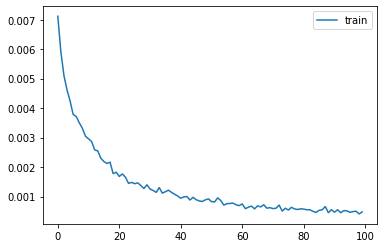

In [190]:
#Plotting Loss over Epochs
plt.plot(acorn_trend.history.history['loss'], label='train')
plt.legend()
plt.show()

In [191]:
#Best loss and MAE
print(min(acorn_trend.history.history['loss']))
print(min(acorn_trend.history.history['mean_absolute_error']))

0.00041218406408369105
0.015928522


In [218]:
#Evauating Model
df_out = {}

for i in ids: 
    df_out[i] = {}
    print(acorn_trend.evaluate(df_trend[i]["XTest"], df_trend[i]["yTest"]))
    df_out[i] = acorn_trend.predict(df_trend[i]["XTest"])
    df_out[i] = df_out[i].reshape(df_out[i].shape[0], df_out[i].shape[1])
    df_out[i] = df_scaled[i]['Scaler'].inverse_transform(df_out[i])

123/123 [==============================] - 0s 2ms/step
[0.05970609225938475, 0.21315741539001465]
123/123 [==============================] - 0s 2ms/step
[0.011082576474220288, 0.08782748132944107]
123/123 [==============================] - 0s 1ms/step
[0.1057057736244628, 0.2985056936740875]
123/123 [==============================] - 0s 1ms/step
[0.008394124107511064, 0.07514432817697525]
123/123 [==============================] - 0s 1ms/step
[0.022172509624463755, 0.12379942834377289]
123/123 [==============================] - 0s 1ms/step
[0.010790268458971164, 0.0822925865650177]
123/123 [==============================] - 0s 1ms/step
[0.05542224951512445, 0.20557428896427155]
123/123 [==============================] - 0s 1ms/step
[0.026366978618732797, 0.13439330458641052]
123/123 [==============================] - 0s 1ms/step
[0.00713097229145649, 0.06856142729520798]
123/123 [==============================] - 0s 1ms/step
[0.0021717614017245247, 0.038575444370508194]
123/123 [======

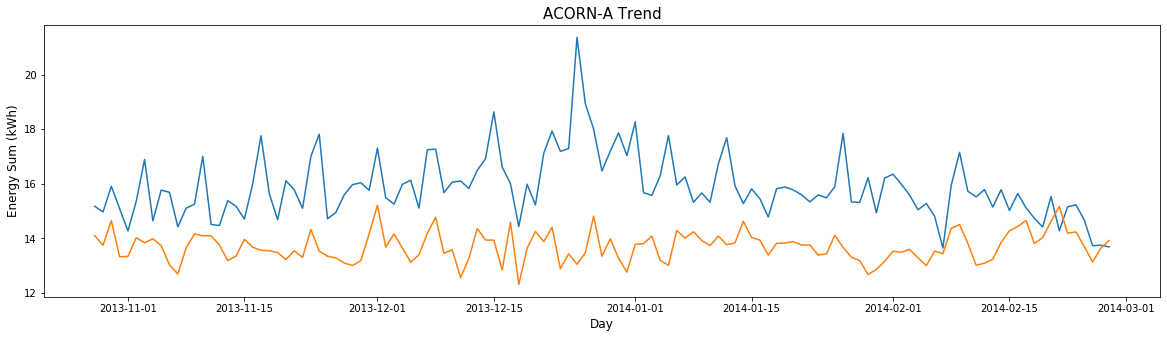

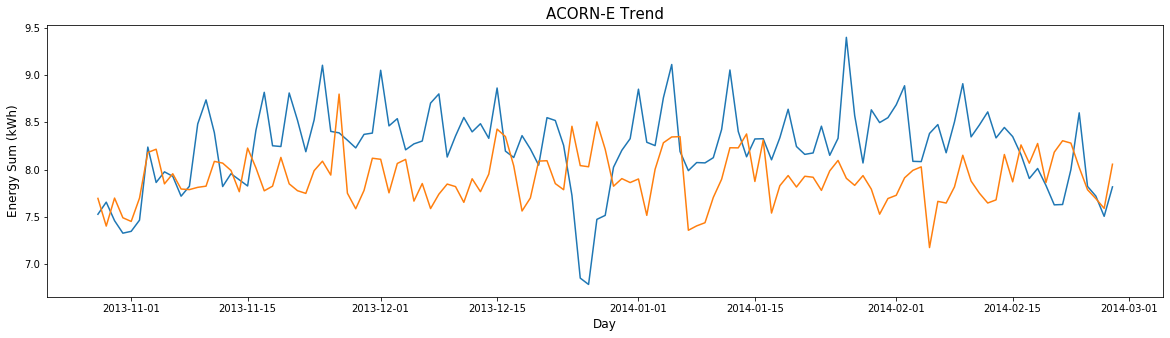

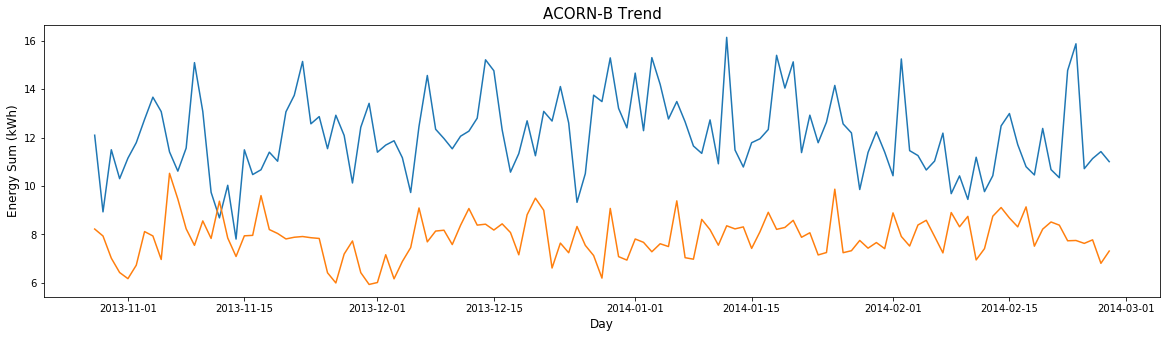

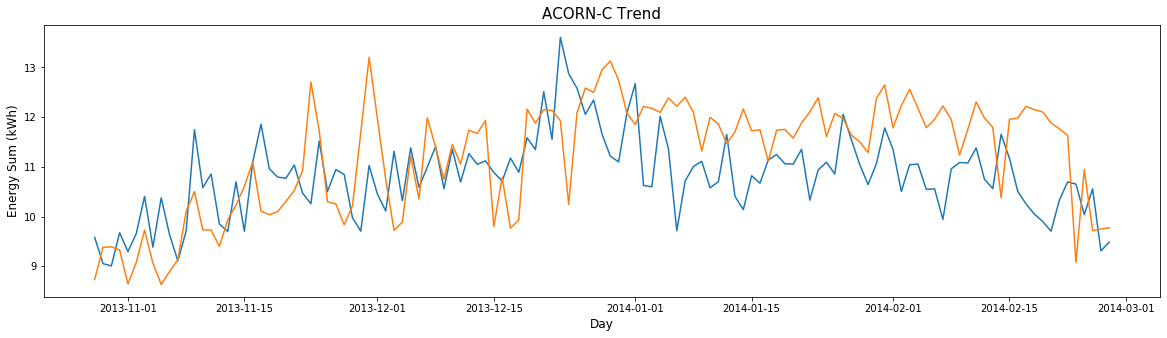

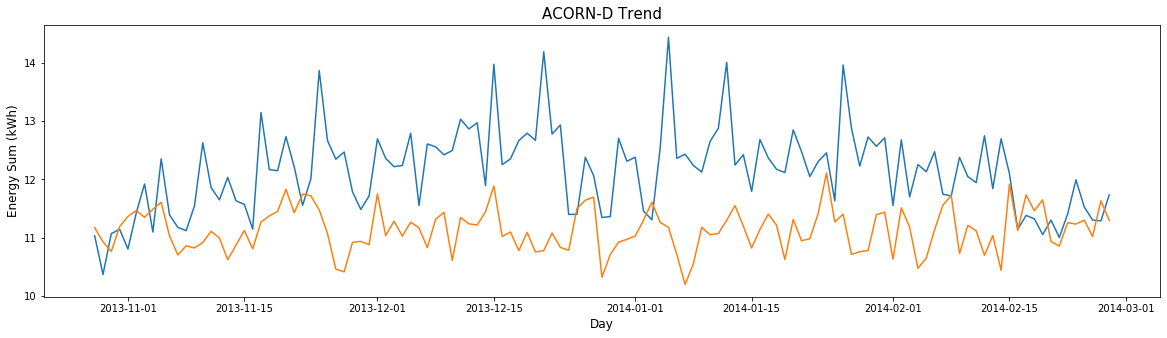

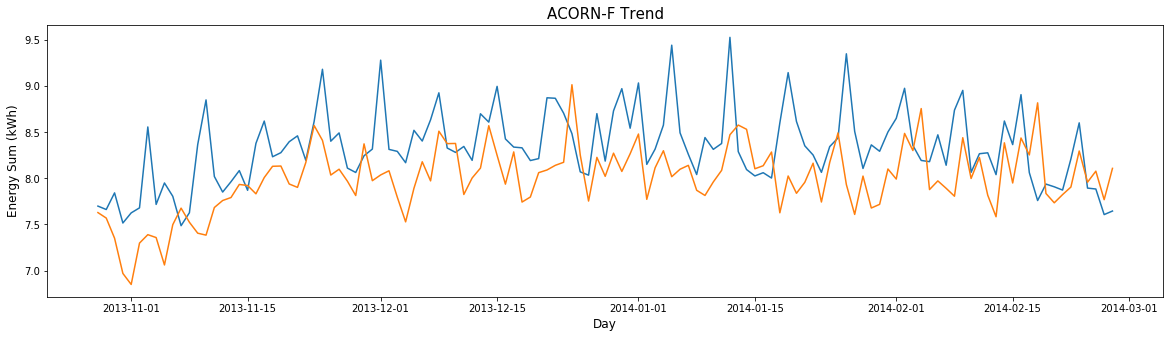

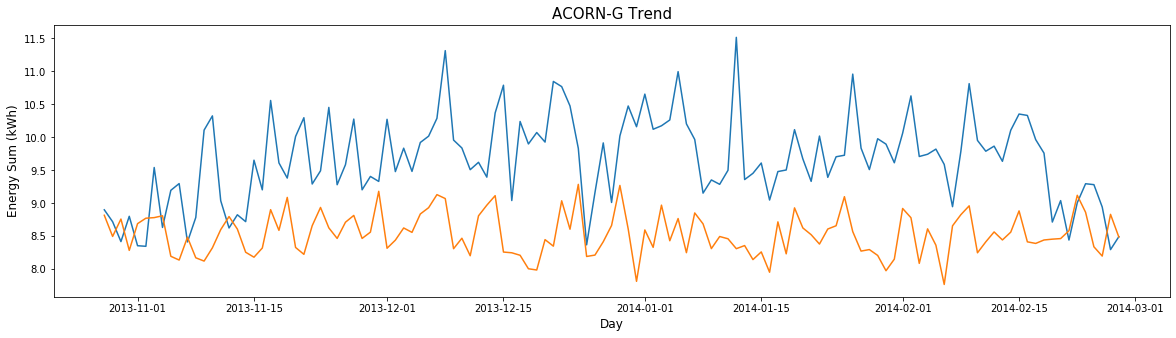

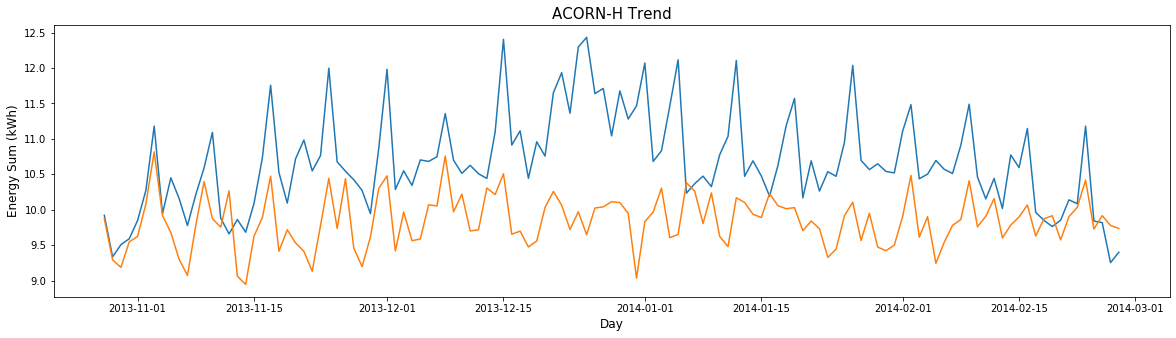

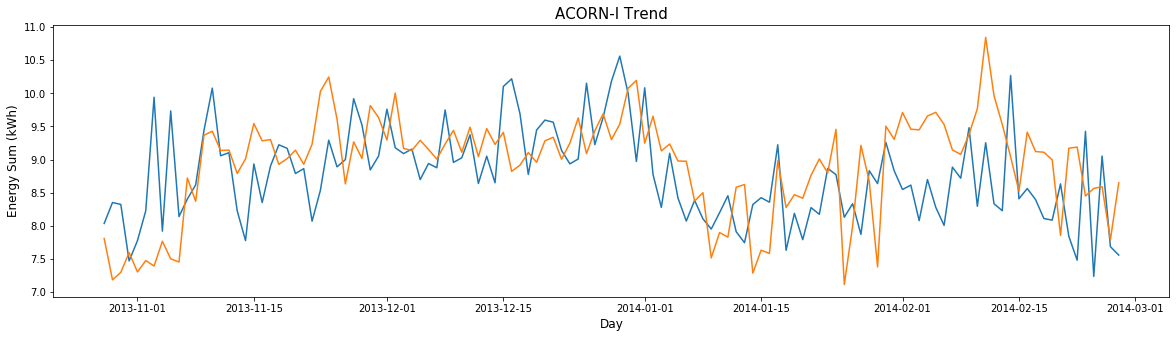

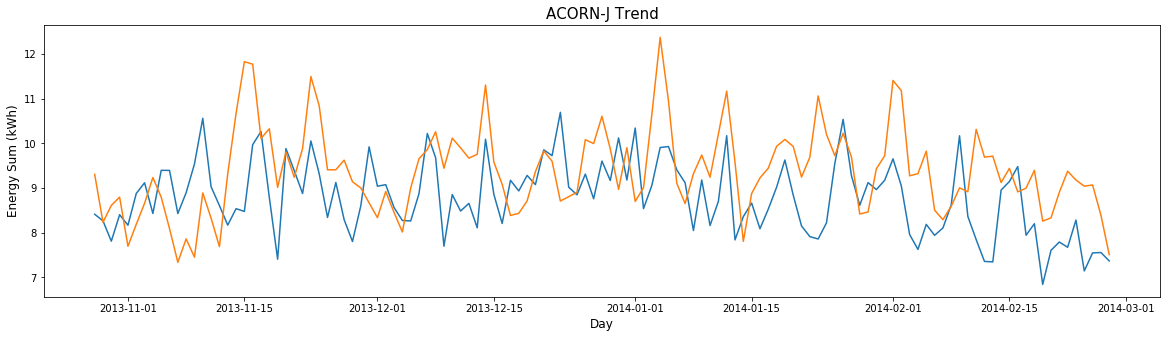

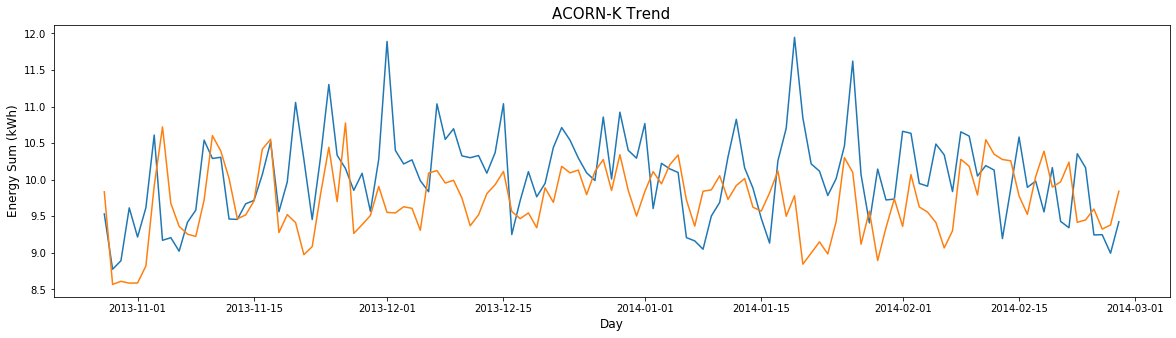

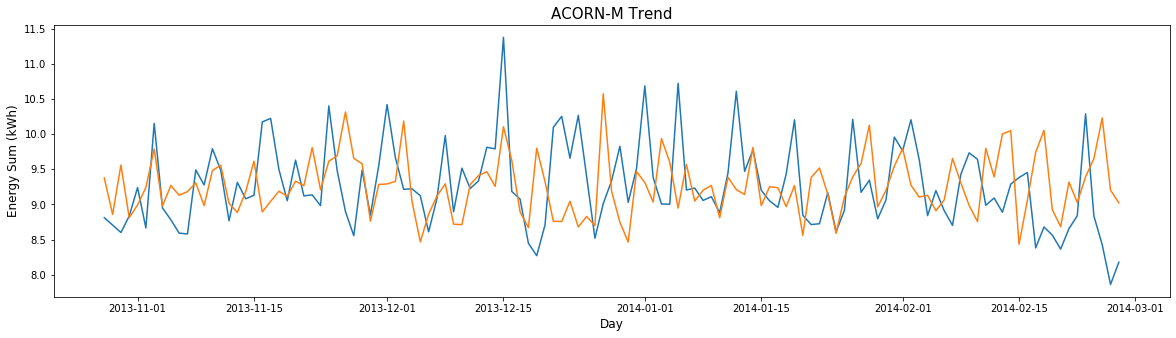

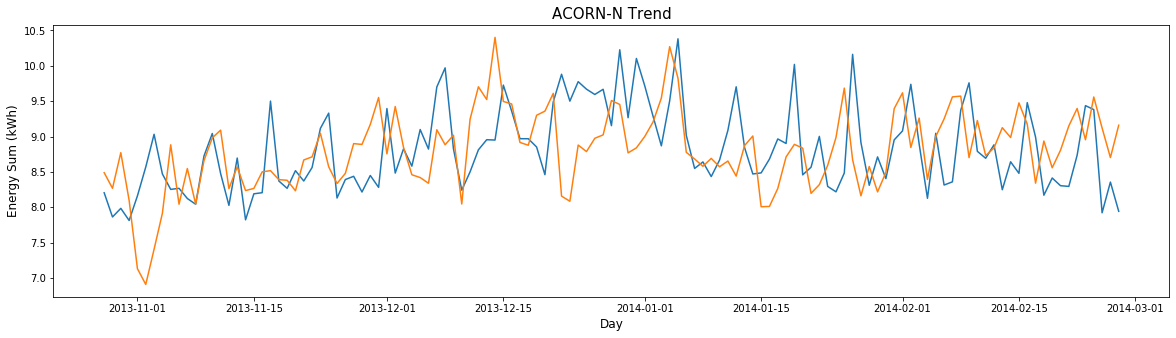

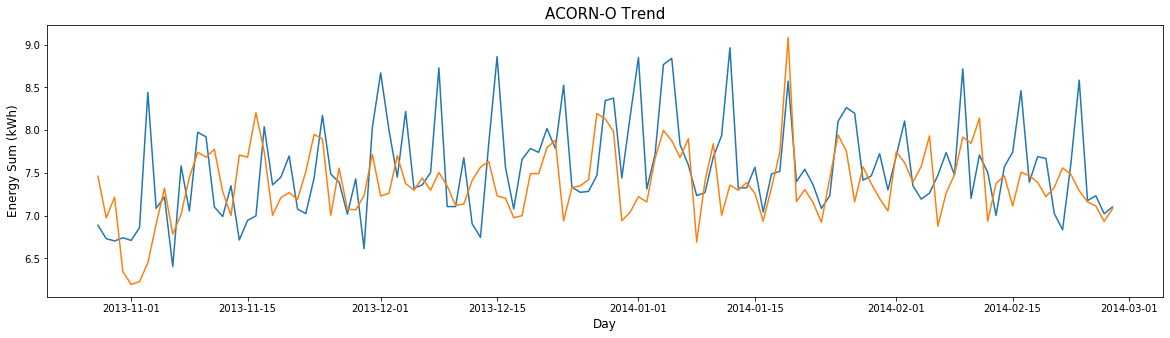

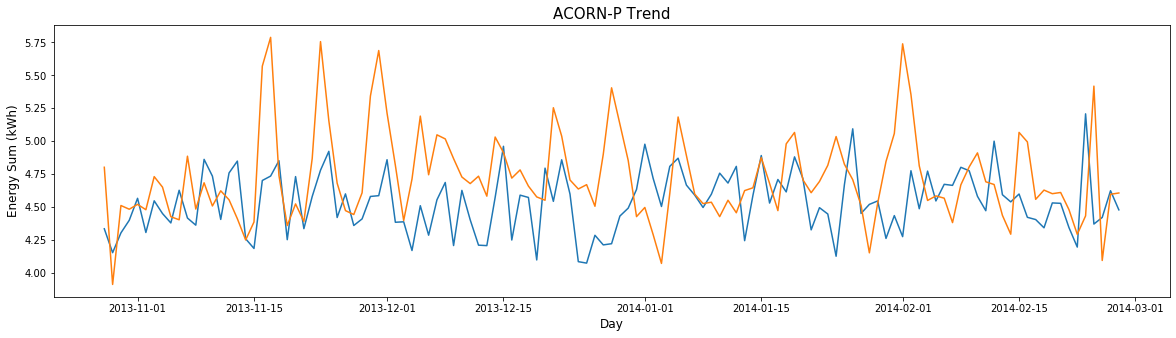

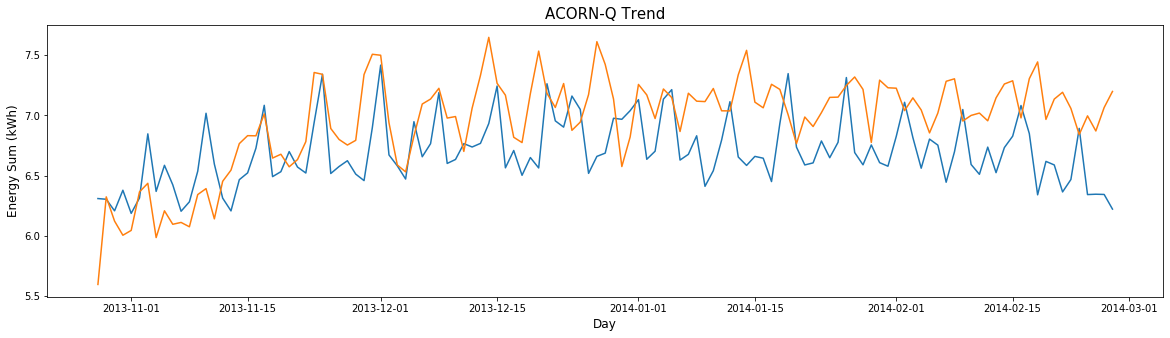

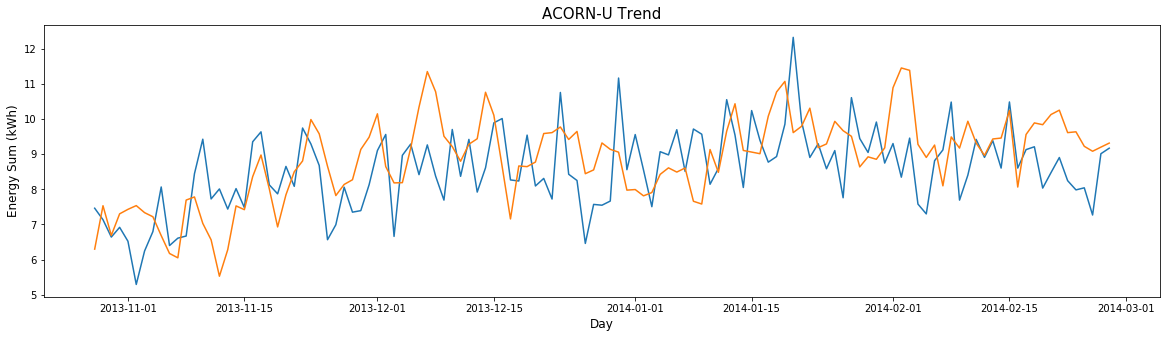

In [220]:
#Plotting results
for i in ids:

    plt.figure(figsize=(20, 5))

    plt.plot(df_new[i]["Test"].index[30:], df_new[i]["Test"][30:])
    plt.plot(df_new[i]["Test"].index[30:], df_out[i])
    plt.title(i + ' Trend', fontsize = 15)
    plt.ylabel('Energy Sum (kWh)', fontsize = 12)
    plt.xlabel('Day', fontsize = 12)

    plt.show()

- Forecast:

In [194]:
#Model
acorn_forecast = model(df_forecast['ACORN-A']["XTrain"], time_distributed = True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 30, 64)            16896     
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_22 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_23 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 30, 64)           

In [195]:
#Fitting
for i in ids: 
    print("Fitting to", i)
    acorn_forecast.fit(df_forecast[i]["XTrain"], df_forecast[i]["yTrain"], epochs = 100)

Fitting to ACORN-A
Epoch 1/100
553/553 [==============================] - 3s 6ms/step - loss: 0.0948 - mean_absolute_error: 0.2380
Epoch 2/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0563 - mean_absolute_error: 0.1869
Epoch 3/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0482 - mean_absolute_error: 0.1755
Epoch 4/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0433 - mean_absolute_error: 0.1648
Epoch 5/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0374 - mean_absolute_error: 0.1531
Epoch 6/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0353 - mean_absolute_error: 0.1483
Epoch 7/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0342 - mean_absolute_error: 0.1454
Epoch 8/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0329 - mean_absolute_error: 0.1433
Epoch 9/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0313 - m

553/553 [==============================] - 4s 7ms/step - loss: 0.0184 - mean_absolute_error: 0.1046
Epoch 74/100
553/553 [==============================] - 3s 6ms/step - loss: 0.0184 - mean_absolute_error: 0.1044
Epoch 75/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0189 - mean_absolute_error: 0.1060
Epoch 76/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0184 - mean_absolute_error: 0.1046
Epoch 77/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0182 - mean_absolute_error: 0.1047
Epoch 78/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0175 - mean_absolute_error: 0.1022
Epoch 79/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0180 - mean_absolute_error: 0.1044
Epoch 80/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0177 - mean_absolute_error: 0.1026
Epoch 81/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0176 - mean_absolute_error: 0.1

553/553 [==============================] - 3s 5ms/step - loss: 0.0086 - mean_absolute_error: 0.0683
Epoch 46/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0703
Epoch 47/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0084 - mean_absolute_error: 0.0673
Epoch 48/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0086 - mean_absolute_error: 0.0686
Epoch 49/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0087 - mean_absolute_error: 0.0687
Epoch 50/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0086 - mean_absolute_error: 0.0682
Epoch 51/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0085 - mean_absolute_error: 0.0676
Epoch 52/100
553/553 [==============================] - 3s 6ms/step - loss: 0.0084 - mean_absolute_error: 0.0676
Epoch 53/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0083 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0628
Epoch 18/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0615
Epoch 19/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0613
Epoch 20/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0613
Epoch 21/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0613
Epoch 22/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0065 - mean_absolute_error: 0.0600
Epoch 23/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0064 - mean_absolute_error: 0.0592
Epoch 24/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0063 - mean_absolute_error: 0.0593
Epoch 25/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0063 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0428
Epoch 90/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0040 - mean_absolute_error: 0.0433
Epoch 91/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0423
Epoch 92/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0422
Epoch 93/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0422
Epoch 94/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0040 - mean_absolute_error: 0.0429
Epoch 95/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0038 - mean_absolute_error: 0.0420
Epoch 96/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0038 - mean_absolute_error: 0.0422
Epoch 97/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0038 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0357
Epoch 62/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0360
Epoch 63/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0351
Epoch 64/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0352
Epoch 65/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0351
Epoch 66/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0345
Epoch 67/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0351
Epoch 68/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0347
Epoch 69/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0

553/553 [==============================] - 1s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0480
Epoch 34/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0485
Epoch 35/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0483
Epoch 36/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0054 - mean_absolute_error: 0.0484
Epoch 37/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0052 - mean_absolute_error: 0.0476
Epoch 38/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0479
Epoch 39/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0052 - mean_absolute_error: 0.0469
Epoch 40/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0050 - mean_absolute_error: 0.0462
Epoch 41/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0052 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 3ms/step - loss: 0.0063 - mean_absolute_error: 0.0568
Epoch 6/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0059 - mean_absolute_error: 0.0543
Epoch 7/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0057 - mean_absolute_error: 0.0531
Epoch 8/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0507
Epoch 9/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0054 - mean_absolute_error: 0.0510
Epoch 10/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0050 - mean_absolute_error: 0.0492
Epoch 11/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0048 - mean_absolute_error: 0.0478
Epoch 12/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0047 - mean_absolute_error: 0.0476
Epoch 13/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0045 - mean_absolute_error: 0.0457


553/553 [==============================] - 2s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0312
Epoch 78/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0317
Epoch 79/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0315
Epoch 80/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0308
Epoch 81/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0314
Epoch 82/100
553/553 [==============================] - 3s 6ms/step - loss: 0.0028 - mean_absolute_error: 0.0314
Epoch 83/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0313
Epoch 84/100
553/553 [==============================] - 4s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0307
Epoch 85/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 4ms/step - loss: 0.0042 - mean_absolute_error: 0.0400
Epoch 50/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0041 - mean_absolute_error: 0.0395
Epoch 51/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0040 - mean_absolute_error: 0.0391
Epoch 52/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0387
Epoch 53/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0040 - mean_absolute_error: 0.0391
Epoch 54/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0387
Epoch 55/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0040 - mean_absolute_error: 0.0386
Epoch 56/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0040 - mean_absolute_error: 0.0382
Epoch 57/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0041 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 4ms/step - loss: 0.0046 - mean_absolute_error: 0.0434
Epoch 22/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0049 - mean_absolute_error: 0.0439
Epoch 23/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0421
Epoch 24/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0043 - mean_absolute_error: 0.0416
Epoch 25/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0432
Epoch 26/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0043 - mean_absolute_error: 0.0410
Epoch 27/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0044 - mean_absolute_error: 0.0416
Epoch 28/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0043 - mean_absolute_error: 0.0408
Epoch 29/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0043 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0323
Epoch 94/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0320
Epoch 95/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0323
Epoch 96/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0315
Epoch 97/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0032 - mean_absolute_error: 0.0317
Epoch 98/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0317
Epoch 99/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0318
Epoch 100/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0315
Fitting to ACORN-I
Epoch 1/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0095 - mean_

553/553 [==============================] - 2s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0255
Epoch 66/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0254
Epoch 67/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0251
Epoch 68/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0247
Epoch 69/100
553/553 [==============================] - 3s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0252
Epoch 70/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0252
Epoch 71/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0245
Epoch 72/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0247
Epoch 73/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 4ms/step - loss: 8.4826e-04 - mean_absolute_error: 0.0206
Epoch 37/100
553/553 [==============================] - 2s 4ms/step - loss: 9.1623e-04 - mean_absolute_error: 0.0213
Epoch 38/100
553/553 [==============================] - 2s 4ms/step - loss: 8.3121e-04 - mean_absolute_error: 0.0201
Epoch 39/100
553/553 [==============================] - 2s 4ms/step - loss: 8.4681e-04 - mean_absolute_error: 0.0204
Epoch 40/100
553/553 [==============================] - 3s 5ms/step - loss: 8.6387e-04 - mean_absolute_error: 0.0204
Epoch 41/100
553/553 [==============================] - 3s 6ms/step - loss: 8.5029e-04 - mean_absolute_error: 0.0203
Epoch 42/100
553/553 [==============================] - 3s 6ms/step - loss: 8.3560e-04 - mean_absolute_error: 0.0199
Epoch 43/100
553/553 [==============================] - 2s 4ms/step - loss: 7.9945e-04 - mean_absolute_error: 0.0194
Epoch 44/100
553/553 [==============================] - 3s 6ms/step - loss: 8

553/553 [==============================] - 3s 5ms/step - loss: 0.0062 - mean_absolute_error: 0.0578
Epoch 7/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0059 - mean_absolute_error: 0.0560
Epoch 8/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0543
Epoch 9/100
553/553 [==============================] - 3s 6ms/step - loss: 0.0052 - mean_absolute_error: 0.0516
Epoch 10/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0051 - mean_absolute_error: 0.0505
Epoch 11/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0486
Epoch 12/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0482
Epoch 13/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0470
Epoch 14/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0044 - mean_absolute_error: 0.0457

553/553 [==============================] - 2s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0282
Epoch 79/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0286
Epoch 80/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0287
Epoch 81/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0281
Epoch 82/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0284
Epoch 83/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0285
Epoch 84/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0281
Epoch 85/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0280
Epoch 86/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0267
Epoch 51/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0258
Epoch 52/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0258
Epoch 53/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0265
Epoch 54/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0255
Epoch 55/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0260
Epoch 56/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0257
Epoch 57/100
553/553 [==============================] - 2s 5ms/step - loss: 0.0018 - mean_absolute_error: 0.0251
Epoch 58/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0337
Epoch 23/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0334
Epoch 24/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0330
Epoch 25/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0026 - mean_absolute_error: 0.0327
Epoch 26/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0318
Epoch 27/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0324
Epoch 28/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0309
Epoch 29/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0320
Epoch 30/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0234
Epoch 95/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0228
Epoch 96/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0229
Epoch 97/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0229
Epoch 98/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0235
Epoch 99/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0232
Epoch 100/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0225
Fitting to ACORN-N
Epoch 1/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0046 - mean_absolute_error: 0.0515
Epoch 2/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0030 - mean_a

553/553 [==============================] - 2s 3ms/step - loss: 7.7296e-04 - mean_absolute_error: 0.0179
Epoch 66/100
553/553 [==============================] - 2s 3ms/step - loss: 7.5244e-04 - mean_absolute_error: 0.0175
Epoch 67/100
553/553 [==============================] - 2s 3ms/step - loss: 7.9581e-04 - mean_absolute_error: 0.0180
Epoch 68/100
553/553 [==============================] - 2s 3ms/step - loss: 7.7658e-04 - mean_absolute_error: 0.0179
Epoch 69/100
553/553 [==============================] - 2s 3ms/step - loss: 7.6849e-04 - mean_absolute_error: 0.0175
Epoch 70/100
553/553 [==============================] - 2s 3ms/step - loss: 7.8703e-04 - mean_absolute_error: 0.0179
Epoch 71/100
553/553 [==============================] - 2s 3ms/step - loss: 7.6906e-04 - mean_absolute_error: 0.0177
Epoch 72/100
553/553 [==============================] - 2s 3ms/step - loss: 7.5566e-04 - mean_absolute_error: 0.0174
Epoch 73/100
553/553 [==============================] - 2s 3ms/step - loss: 7

553/553 [==============================] - 2s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0359
Epoch 37/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0030 - mean_absolute_error: 0.0348
Epoch 38/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0030 - mean_absolute_error: 0.0345
Epoch 39/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0341
Epoch 40/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0340
Epoch 41/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0342
Epoch 42/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0335
Epoch 43/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0337
Epoch 44/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 4ms/step - loss: 0.0041 - mean_absolute_error: 0.0344
Epoch 9/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0043 - mean_absolute_error: 0.0346
Epoch 10/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0040 - mean_absolute_error: 0.0331
Epoch 11/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0038 - mean_absolute_error: 0.0330
Epoch 12/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0037 - mean_absolute_error: 0.0324
Epoch 13/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0038 - mean_absolute_error: 0.0326
Epoch 14/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0037 - mean_absolute_error: 0.0324
Epoch 15/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0307
Epoch 16/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0034 - mean_absolute_error: 0.03

553/553 [==============================] - 3s 5ms/step - loss: 0.0018 - mean_absolute_error: 0.0220
Epoch 81/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0021 - mean_absolute_error: 0.0228
Epoch 82/100
553/553 [==============================] - 3s 5ms/step - loss: 0.0020 - mean_absolute_error: 0.0226
Epoch 83/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0226
Epoch 84/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0220
Epoch 85/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0222
Epoch 86/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0219
Epoch 87/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0222
Epoch 88/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0238
Epoch 53/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0015 - mean_absolute_error: 0.0240
Epoch 54/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0236
Epoch 55/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0239
Epoch 56/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0236
Epoch 57/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0235
Epoch 58/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0232
Epoch 59/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0232
Epoch 60/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0346
Epoch 25/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0343
Epoch 26/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0340
Epoch 27/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0335
Epoch 28/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0330
Epoch 29/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0329
Epoch 30/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0322
Epoch 31/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0324
Epoch 32/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0

553/553 [==============================] - 2s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0242
Epoch 97/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0246
Epoch 98/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0238
Epoch 99/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0241
Epoch 100/100
553/553 [==============================] - 2s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0243


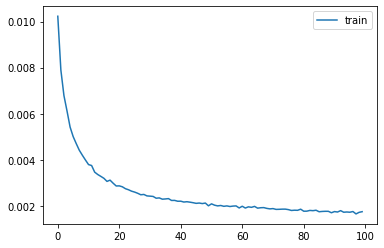

In [196]:
#Plotting Loss over Epochs
plt.plot(acorn_forecast.history.history['loss'], label='train')
plt.legend()
plt.show()

In [197]:
#Best loss and MAE
print(min(acorn_forecast.history.history['loss']))
print(min(acorn_forecast.history.history['mean_absolute_error']))

0.0016515569169424594
0.02380583


In [198]:
#Evauating Model
for i in ids: 
    print(acorn_forecast.evaluate(df_forecast[i]["XTest"], df_forecast[i]["yTest"])

94/94 [==============================] - 1s 9ms/step
[0.060091418233957694, 0.21685974299907684]
94/94 [==============================] - 0s 1ms/step
[0.02184518819001127, 0.1188429594039917]
94/94 [==============================] - 0s 1ms/step
[0.09407832616187156, 0.28534117341041565]
94/94 [==============================] - 0s 1ms/step
[0.014408579254721074, 0.10214363038539886]
94/94 [==============================] - 0s 919us/step
[0.03023765798895917, 0.15133234858512878]
94/94 [==============================] - 0s 1ms/step
[0.020608458212239944, 0.11106948554515839]
94/94 [==============================] - 0s 997us/step
[0.06574418427462274, 0.23038820922374725]
94/94 [==============================] - 0s 945us/step
[0.03268885339035633, 0.14758552610874176]
94/94 [==============================] - 0s 1ms/step
[0.013478209680699288, 0.0958123728632927]
94/94 [==============================] - 0s 1ms/step
[0.0035785955991199676, 0.04707188159227371]
94/94 [=======================

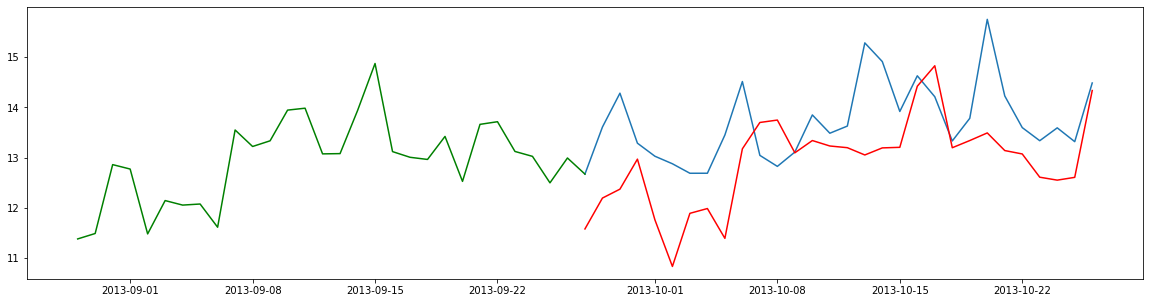

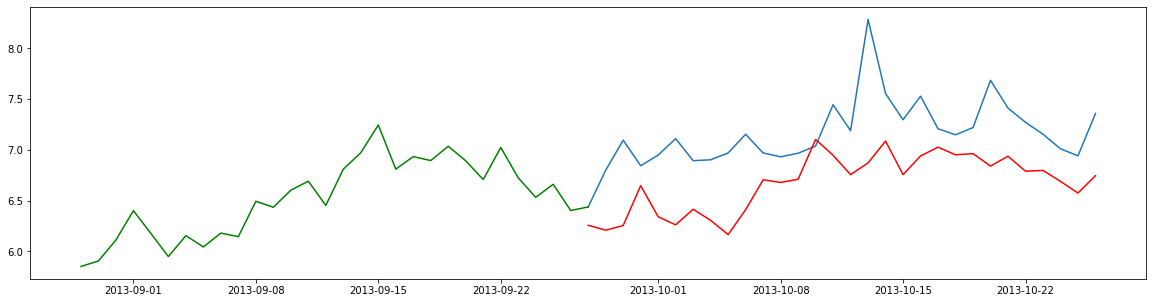

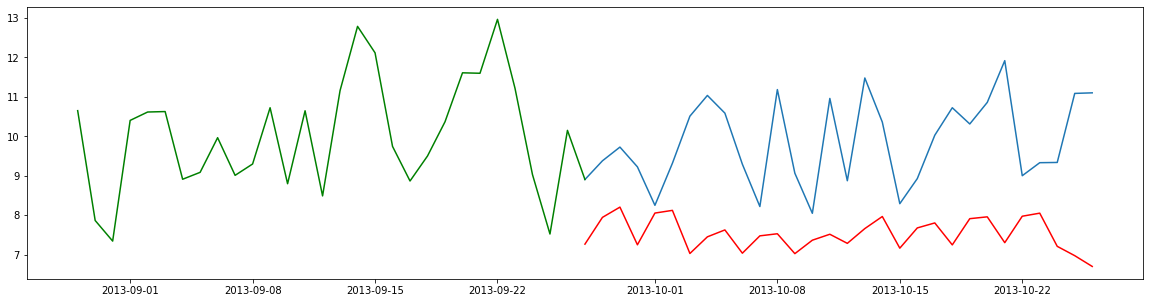

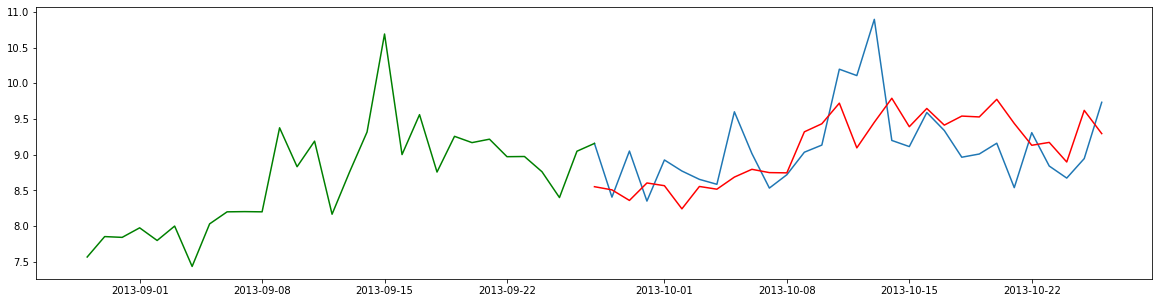

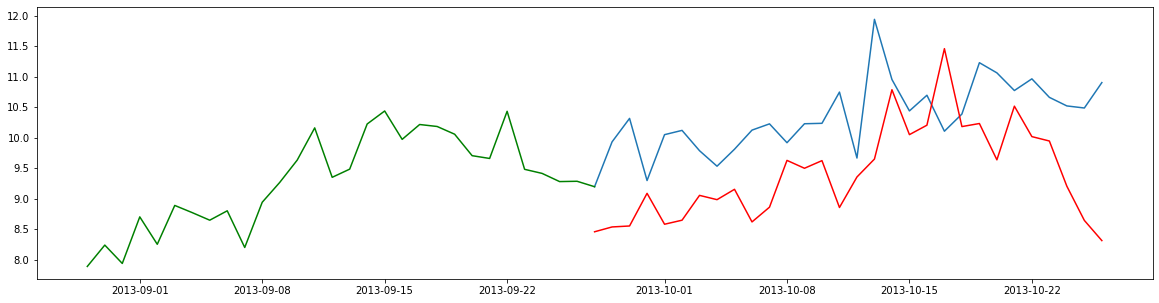

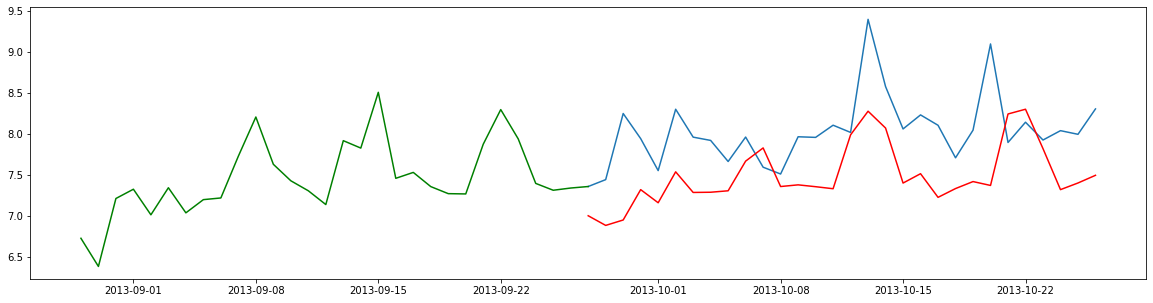

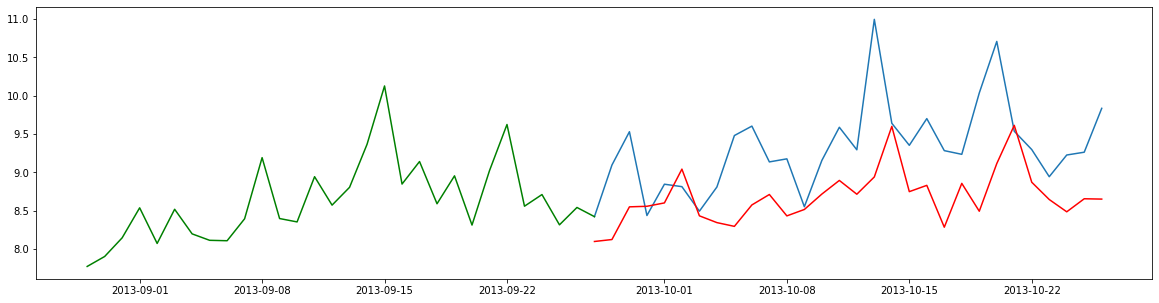

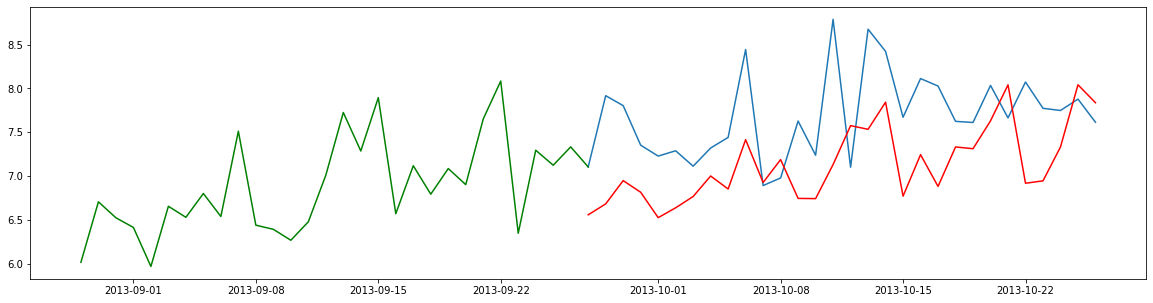

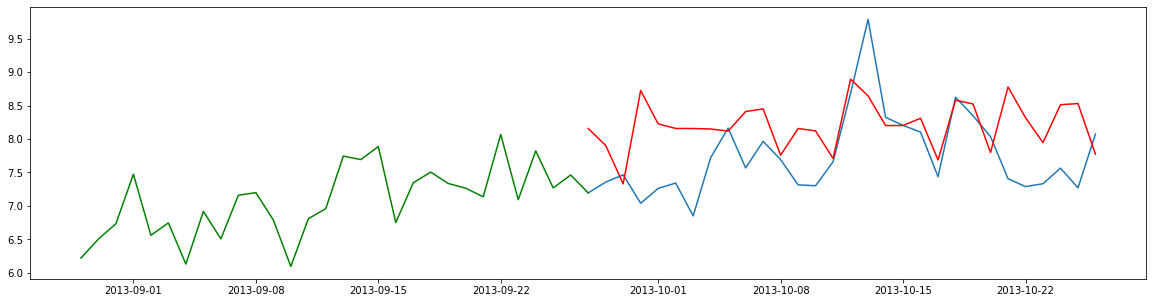

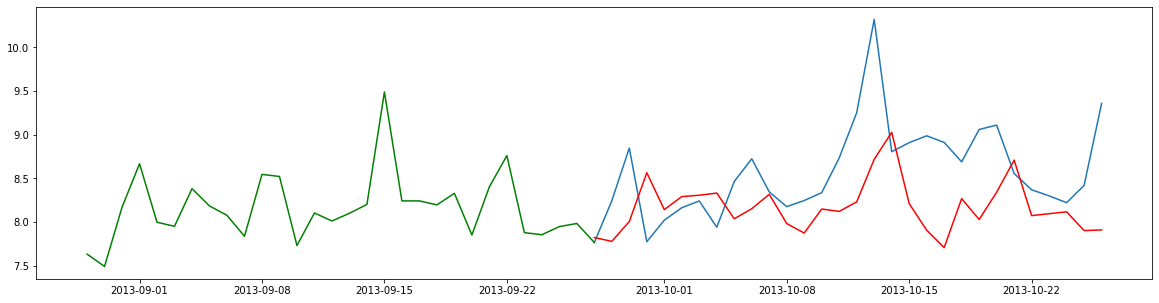

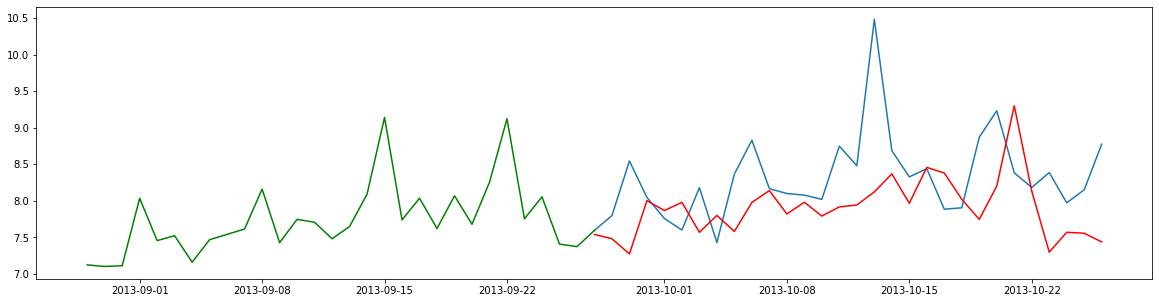

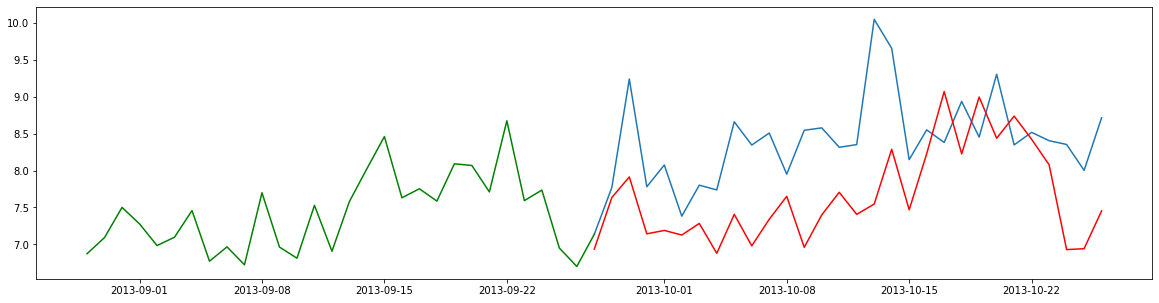

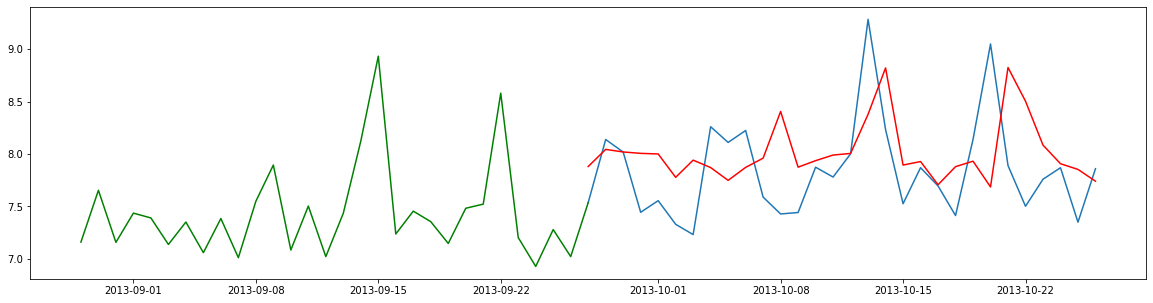

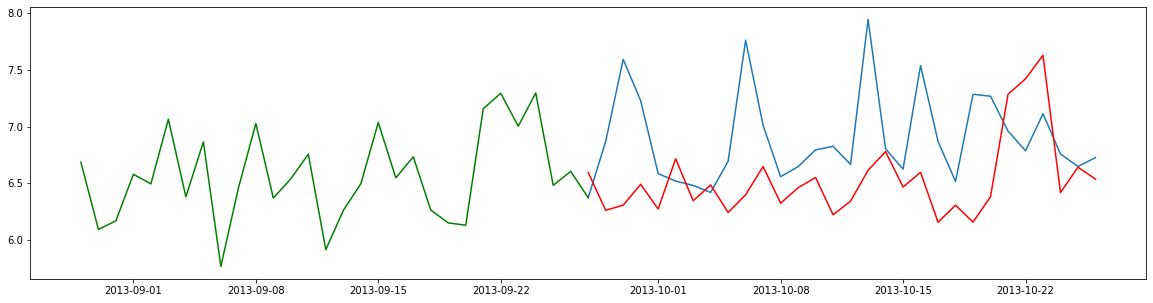

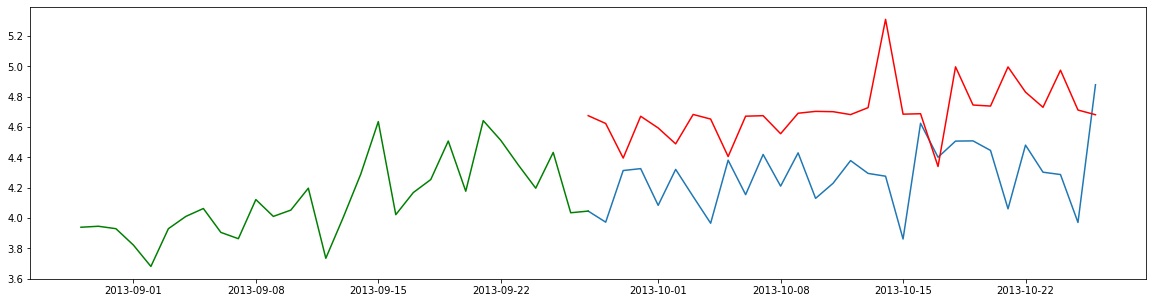

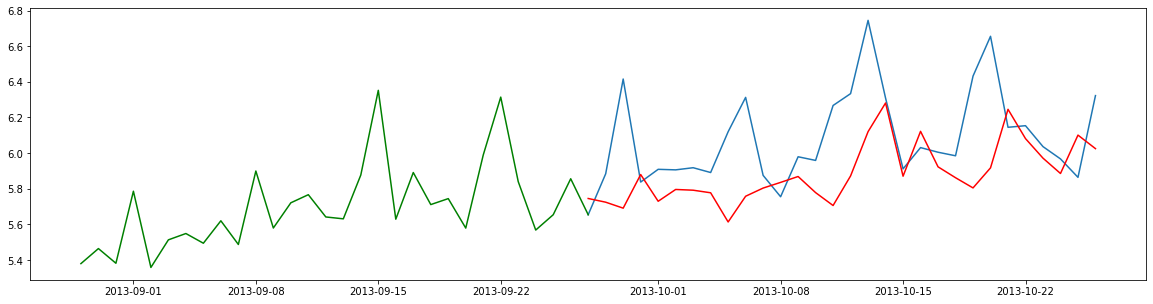

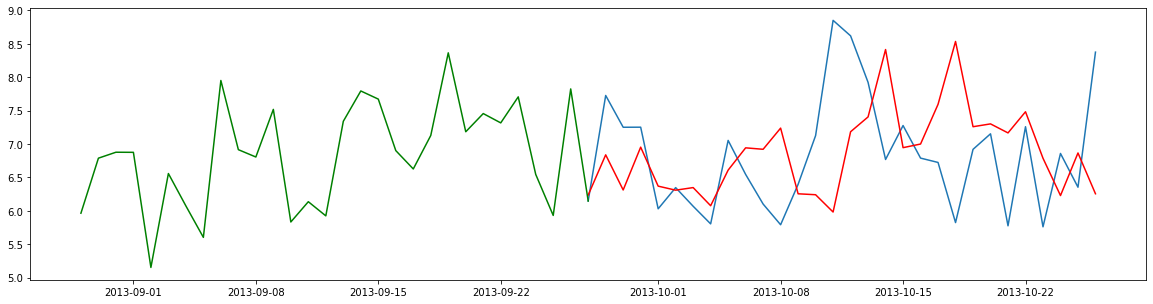

In [201]:
#Plotting Forecasts
n_forecast = 10
days_forward = 3

projections = {}

for i in ids:
    projections[i] = {}
    
    forecasts = forecast(acorn_forecast, df_scaled[i]['Train'], 30, n_forecast, days_forward)
    
    projections[i] = forecast_visualization(df_new[i]["Train"], df_new[i]["Test"], df_scaled[i]['Scaler'],
                           forecasts, n_forecast, days_forward)

In [225]:
maes = []
for i in ids: 
    mae = mean_absolute_error(projections[i]['energy_sum'][:30], projections[i]['Prediction'][:30])
    print('mean absolute error {}: {}'.format(i, mae))
    maes.append(mae)

mean absolute error ACORN-A: 0.9666858583496101
mean absolute error ACORN-E: 0.4920829814365641
mean absolute error ACORN-B: 1.0689419695399982
mean absolute error ACORN-C: 0.4150150475683594
mean absolute error ACORN-D: 0.975872379361979
mean absolute error ACORN-F: 0.291825662740072
mean absolute error ACORN-G: 0.6043776898838298
mean absolute error ACORN-H: 0.6415567036946614
mean absolute error ACORN-I: 0.6026491033917238
mean absolute error ACORN-J: 0.9358448344775394
mean absolute error ACORN-K: 0.48117444725036634
mean absolute error ACORN-L: 0.49113973850524906
mean absolute error ACORN-M: 1.0007915494283037
mean absolute error ACORN-N: 0.430344903169352
mean absolute error ACORN-O: 0.41864148115885386
mean absolute error ACORN-P: 0.5625438169978838
mean absolute error ACORN-Q: 0.20396546465555834
mean absolute error ACORN-U: 0.7845344000225831


In [224]:
np.mean(maes)

0.6315548906462493

     Combining Models

In [205]:
n_forecast = 10
days_forward = 3

- Using Acorn-Trained Model to Forecast Overall Energy Consumption:

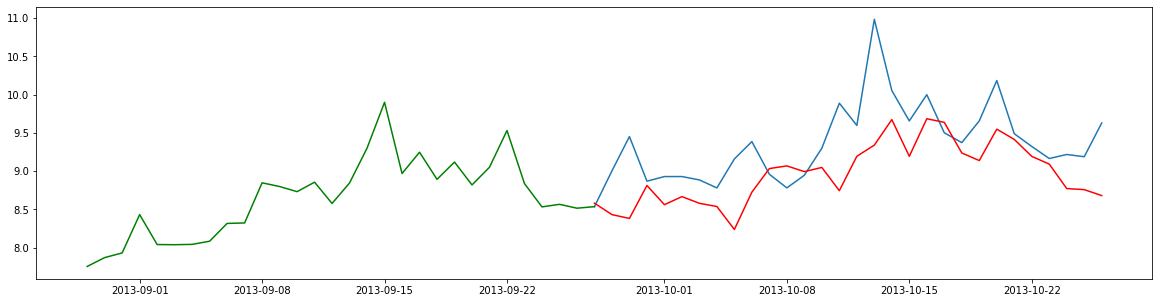

In [206]:
forecasts = forecast(acorn_forecast, scaled_energytrain, 30, n_forecast, days_forward)
    
projections = forecast_visualization(energytrain_df, energytest_df, scaler_energy, forecasts, n_forecast, days_forward)

In [207]:
mae = mean_absolute_error(projections['energy_sum'][:30], projections['Prediction'][:30])
print('mean absolute error: {}'.format(mae))

mean absolute error: 0.43439047026906075


- Using Overal Energy Model to Forecast Energy Consumption per Acorn:

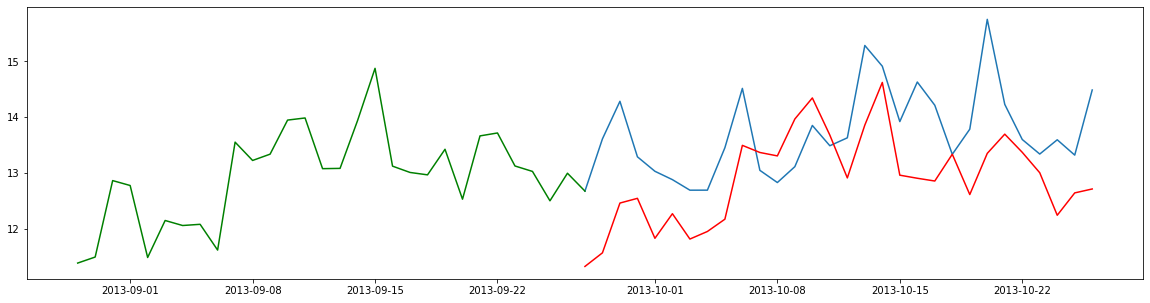

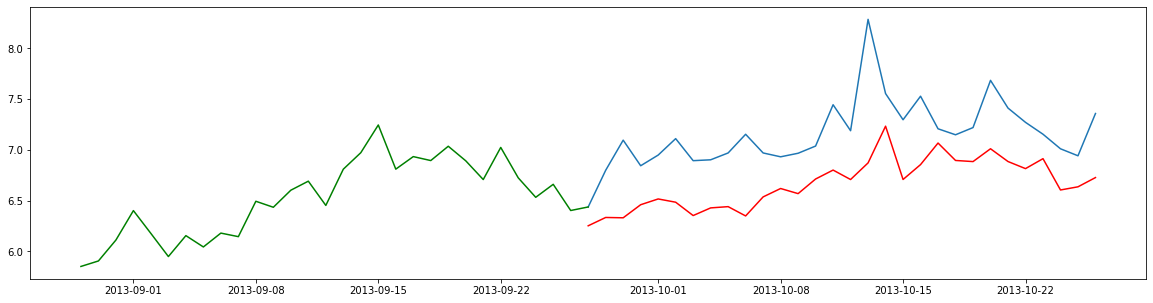

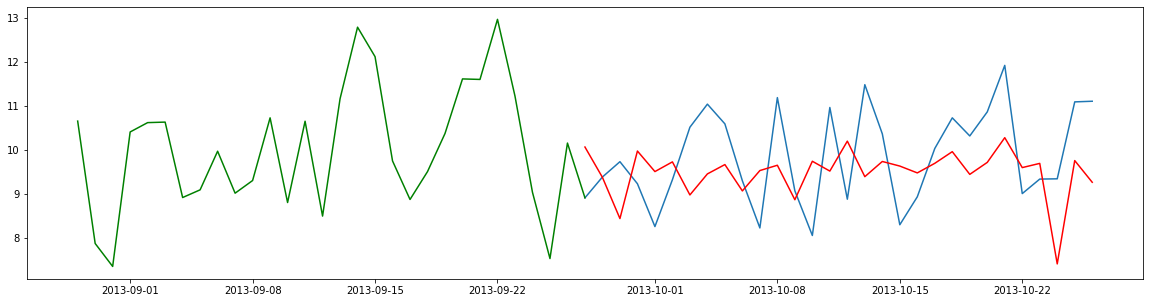

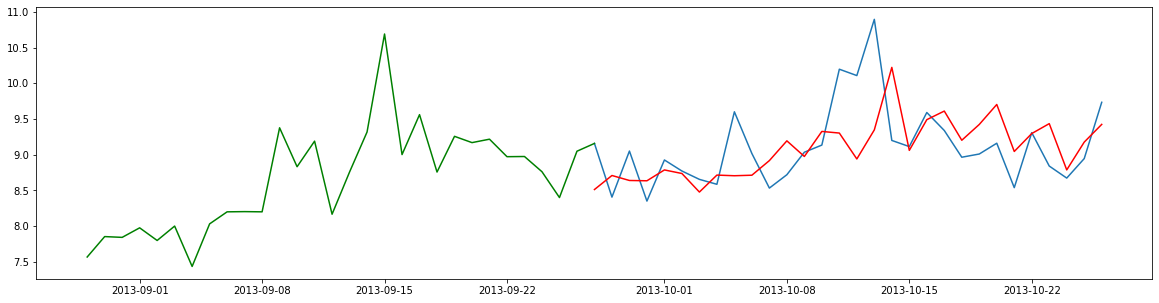

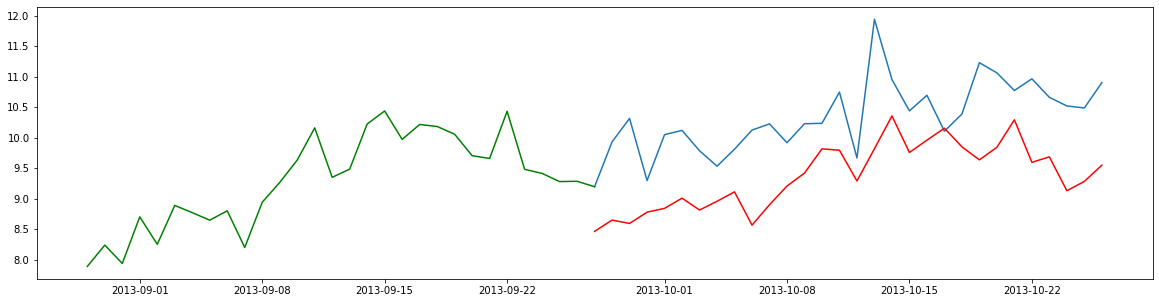

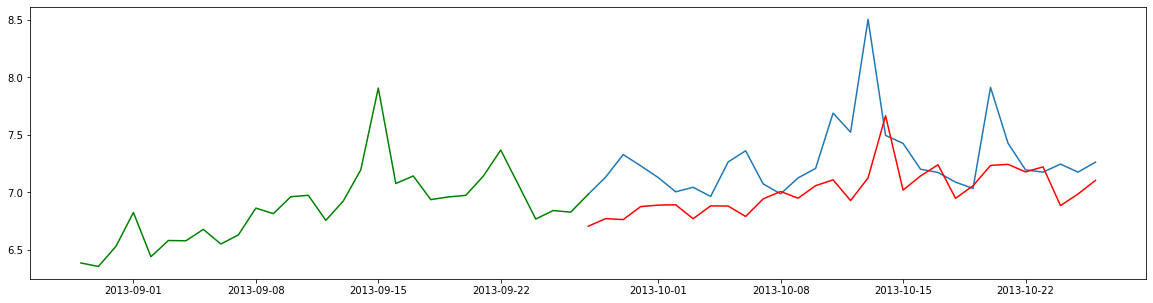

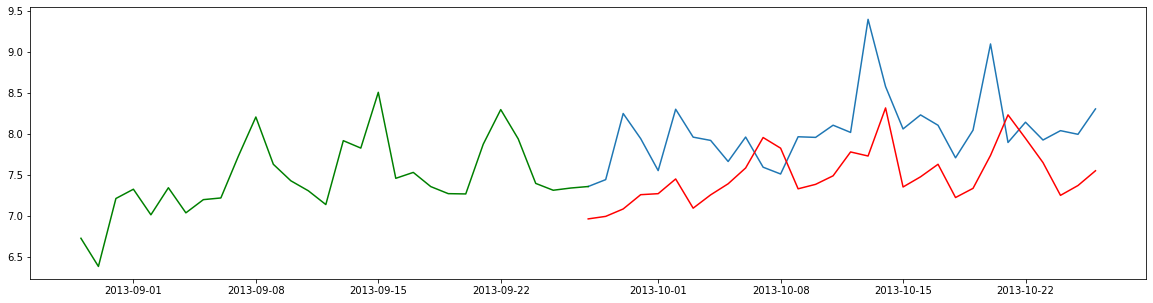

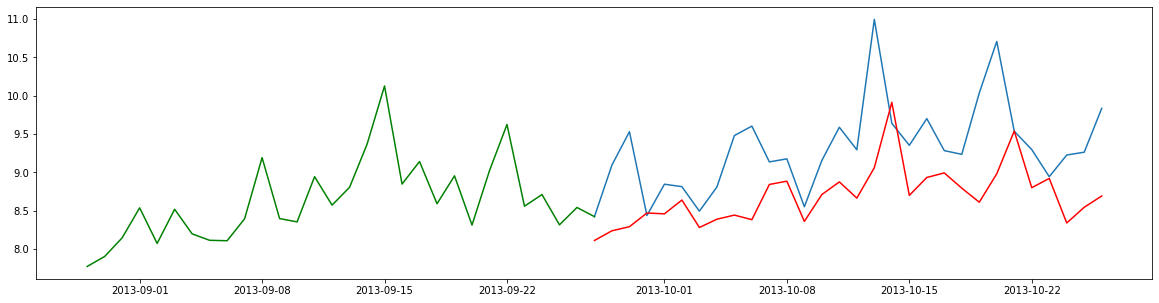

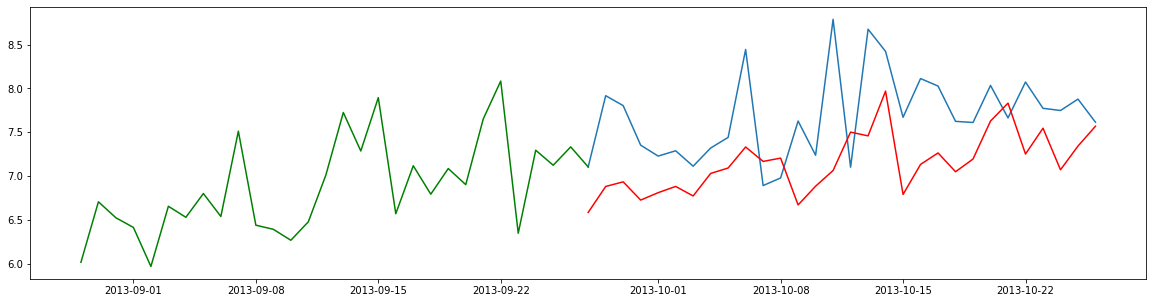

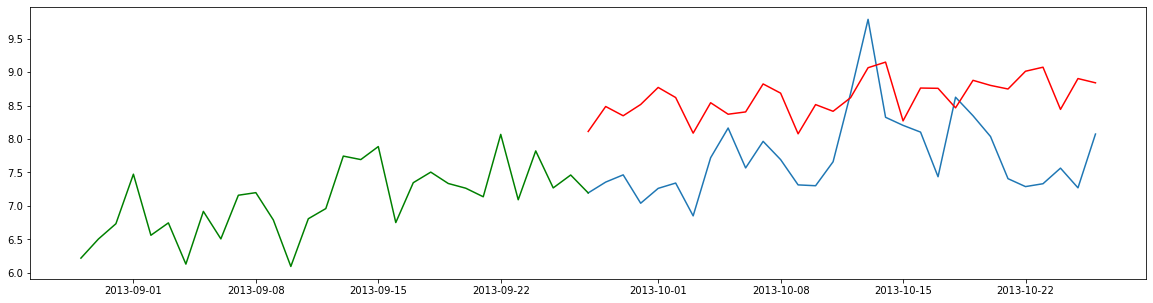

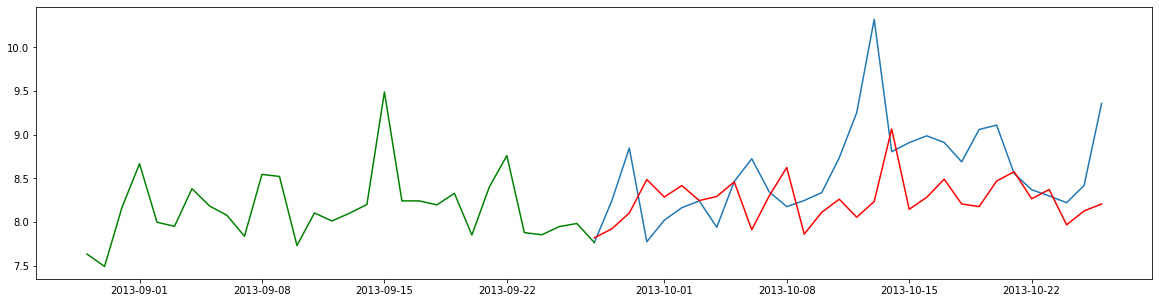

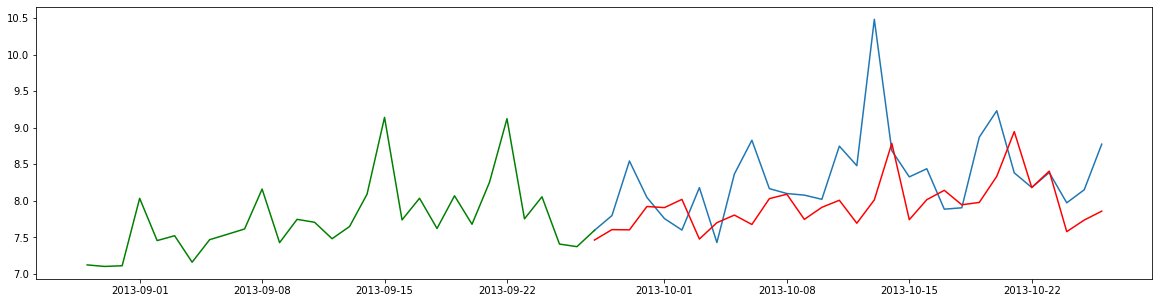

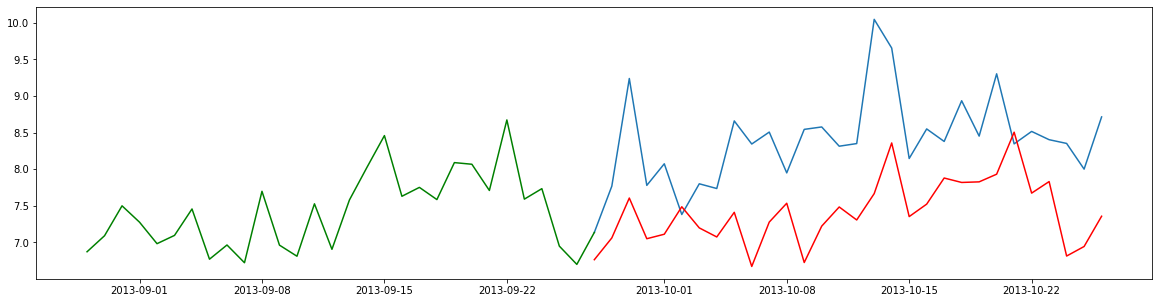

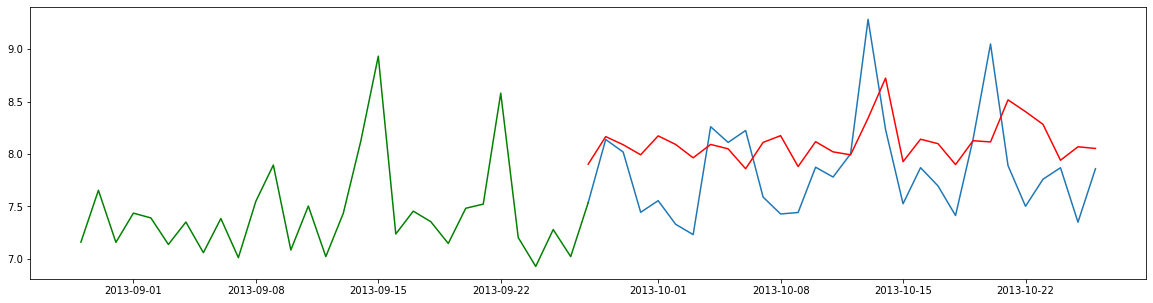

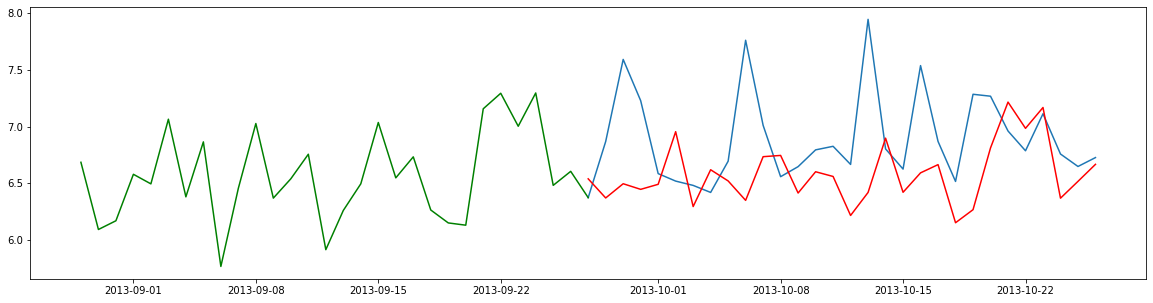

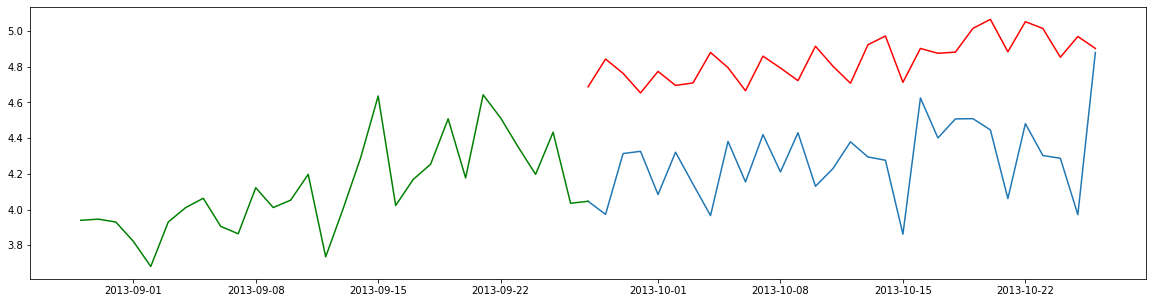

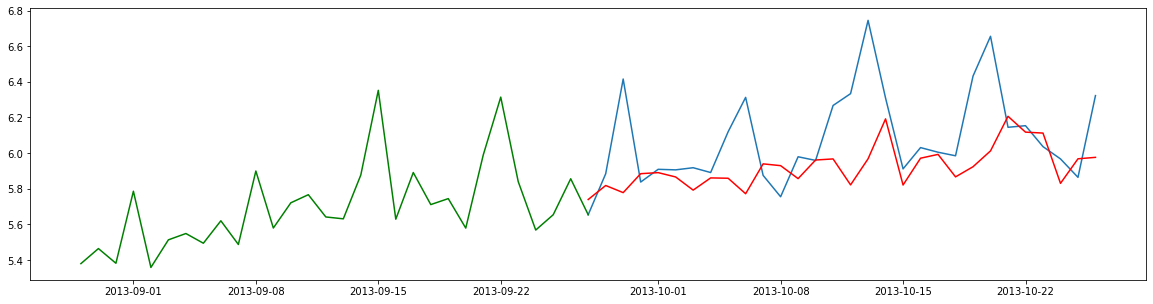

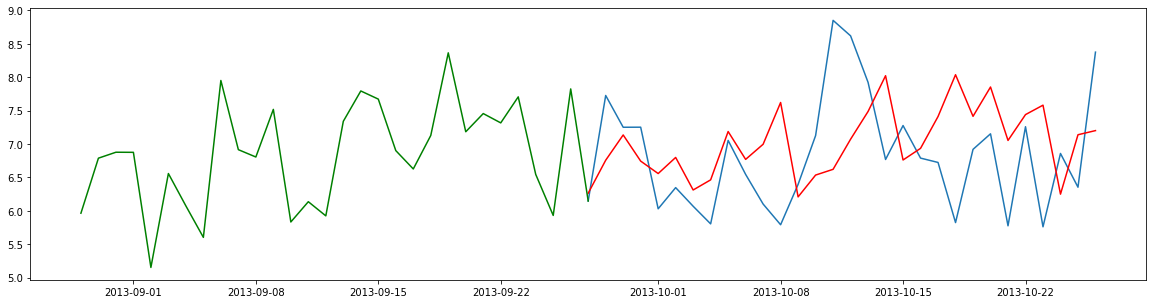

In [231]:
projections1 = {}

for i in ids:
    
    projections1[i] = {}

    forecasts1 = forecast(model_forecast, df_scaled[i]['Train'], 30, n_forecast, days_forward)

    projections1[i] = forecast_visualization(df_new[i]["Train"], df_new[i]["Test"], df_scaled[i]['Scaler'],
                               forecasts1, n_forecast, days_forward)

In [235]:
maes1 = []
for i in ids: 
    mae1 = mean_absolute_error(projections1[i]['energy_sum'][:30], projections1[i]['Prediction'][:30])
    print('mean absolute error {}: {}'.format(i, mae1))
    maes1.append(mae1)

mean absolute error ACORN-A: 0.9666858583496101
mean absolute error ACORN-E: 0.4920829814365641
mean absolute error ACORN-B: 1.0689419695399982
mean absolute error ACORN-C: 0.4150150475683594
mean absolute error ACORN-D: 0.975872379361979
mean absolute error ACORN-F: 0.291825662740072
mean absolute error ACORN-G: 0.6043776898838298
mean absolute error ACORN-H: 0.6415567036946614
mean absolute error ACORN-I: 0.6026491033917238
mean absolute error ACORN-J: 0.9358448344775394
mean absolute error ACORN-K: 0.48117444725036634
mean absolute error ACORN-L: 0.49113973850524906
mean absolute error ACORN-M: 1.0007915494283037
mean absolute error ACORN-N: 0.430344903169352
mean absolute error ACORN-O: 0.41864148115885386
mean absolute error ACORN-P: 0.5625438169978838
mean absolute error ACORN-Q: 0.20396546465555834
mean absolute error ACORN-U: 0.7845344000225831


In [236]:
np.mean(maes1)

0.6315548906462493

     Model Using All Features

In [ ]:
def scalera(train_df, test_df):
    '''
    
    '''
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train = scaler.fit_transform(train_df)
    scaled_test = scaler.transform(test_df)
    
    scaler_target = MinMaxScaler(feature_range=(0,1))
    scaled_target = scaler_target.fit(pd.DataFrame(train_df.iloc[:,-1]))
    
    return scaler, scaler_target, scaled_train, scaled_test

In [ ]:
#Scaling Data
scaler_features, scaler_target, scaled_featurestrain, scaled_featurestest = scalera(energytrain_df[['Avg.Dawn','Avg.Morning_Afternoon',
                                                                                                    'Avg.Evening','Avg.Night', 'energy_sum']],
                                                              energytest_df[['Avg.Dawn','Avg.Morning_Afternoon',
                                                                                'Avg.Evening','Avg.Night', 'energy_sum']])

In [443]:
#Creating X_train, y_train, X_test, y_test (FOR TREND)
xtr_trend, ytr_trend = create_timeseries(scaled_featurestrain, 30, 1, n_features = scaled_featurestrain.shape[1])
ytr_trend = ytr_trend[:,:,-1:].flatten()
xte_trend, yte_trend = create_timeseries(scaled_featurestest, 30, 1, n_features = scaled_featurestest.shape[1])
yte_trend = yte_trend[:,:,-1:].flatten()

In [444]:
print(xtr_trend.shape)
print(ytr_trend.shape)
print(xte_trend.shape)
print(yte_trend.shape)

(643, 30, 5)
(643,)
(123, 30, 5)
(123,)


In [441]:
#Creating X_train, y_train, X_test, y_test (FOR Forecast)
xtr_fore, ytr_fore = create_timeseries(scaled_featurestrain, 30, timestepsy = 30,
                                       n_features = scaled_featurestrain.shape[1])

xte_fore, yte_fore = create_timeseries(scaled_featurestest, 30, timestepsy = 30,
                                       n_features = scaled_featurestest.shape[1])

In [442]:
print(xtr_fore.shape)
print(ytr_fore.shape)
print(xte_fore.shape)
print(yte_fore.shape)

(614, 30, 5)
(614, 30, 5)
(94, 30, 5)
(94, 30, 5)


- Energy Trend:

In [445]:
trend_features = model(xtr_trend, time_distributed = False)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 30, 64)            17920     
_________________________________________________________________
dropout_73 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_92 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_74 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_93 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_75 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_94 (LSTM)               (None, 30, 64)          

In [446]:
#Fit
trend_features.fit(xtr_trend, ytr_trend, epochs = 100)

Epoch 1/100
643/643 [==============================] - 10s 16ms/step - loss: 0.0403 - mean_absolute_error: 0.1408 3s - loss: 0.0523 - mean_absolute_error:
Epoch 2/100
643/643 [==============================] - 4s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.0983
Epoch 3/100
643/643 [==============================] - 4s 6ms/step - loss: 0.0178 - mean_absolute_error: 0.0969
Epoch 4/100
643/643 [==============================] - 5s 8ms/step - loss: 0.0121 - mean_absolute_error: 0.0809
Epoch 5/100
643/643 [==============================] - 6s 9ms/step - loss: 0.0148 - mean_absolute_error: 0.0891
Epoch 6/100
643/643 [==============================] - 6s 10ms/step - loss: 0.0128 - mean_absolute_error: 0.0805
Epoch 7/100
643/643 [==============================] - 6s 9ms/step - loss: 0.0141 - mean_absolute_error: 0.0852
Epoch 8/100
643/643 [==============================] - 6s 9ms/step - loss: 0.0118 - mean_absolute_error: 0.0788
Epoch 9/100
643/643 [==============================] - 7s 11

643/643 [==============================] - 4s 6ms/step - loss: 0.0042 - mean_absolute_error: 0.0490
Epoch 73/100
643/643 [==============================] - 4s 6ms/step - loss: 0.0043 - mean_absolute_error: 0.0482
Epoch 74/100
643/643 [==============================] - 4s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0472
Epoch 75/100
643/643 [==============================] - 5s 8ms/step - loss: 0.0044 - mean_absolute_error: 0.0498
Epoch 76/100
643/643 [==============================] - 4s 6ms/step - loss: 0.0045 - mean_absolute_error: 0.0494
Epoch 77/100
643/643 [==============================] - 4s 6ms/step - loss: 0.0038 - mean_absolute_error: 0.0471
Epoch 78/100
643/643 [==============================] - 4s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0452
Epoch 79/100
643/643 [==============================] - 3s 5ms/step - loss: 0.0047 - mean_absolute_error: 0.0499
Epoch 80/100
643/643 [==============================] - 5s 7ms/step - loss: 0.0037 - mean_absolute_error: 0.0

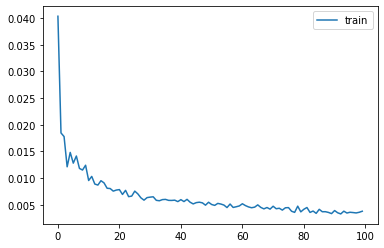

In [447]:
#Plotting Loss over Epochs
plt.plot(trend_features.history.history['loss'], label='train')
plt.legend()
plt.show()

In [448]:
#Best loss and MAE
print(min(trend_features.history.history['loss']))
print(min(trend_features.history.history['mean_absolute_error']))

0.003274071048785864
0.04326045


In [449]:
#Evauating Model
print(trend_features.evaluate(xte_trend, yte_trend))

123/123 [==============================] - 3s 22ms/step
[0.019403104783921706, 0.12122230231761932]


In [450]:
feature_predictions = trend_features.predict(xte_trend)
feature_predictions = feature_predictions.reshape(feature_predictions.shape[0], feature_predictions.shape[1])
feature_predictions = scaler_target.inverse_transform(feature_predictions)

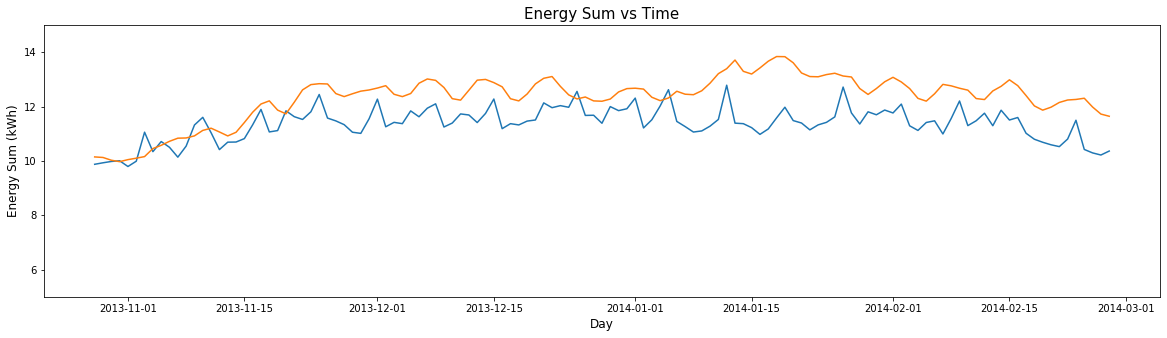

In [451]:
#Plotting results

plt.figure(figsize=(20, 5))

plt.plot(pd.to_datetime(energytest_df.index)[30:], energytest_df['energy_sum'][30:])
plt.plot(pd.to_datetime(energytest_df.index)[30:], feature_predictions)
plt.title('Energy Sum vs Time', fontsize = 15)
plt.ylabel('Energy Sum (kWh)', fontsize = 12)
plt.xlabel('Day', fontsize = 12)
plt.ylim(5, 15)
  
plt.show()

- Energy Forecast:

In [428]:
forecast_features = model(xtr_fore, time_distributed = True, n_features_output = 5)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 30, 64)            17920     
_________________________________________________________________
dropout_69 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_87 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_70 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_88 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_71 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 30, 64)          

In [429]:
#Fit
forecast_features.fit(xtr_fore, ytr_fore, epochs = 100)

Epoch 1/100
614/614 [==============================] - 8s 14ms/step - loss: 0.0700 - mean_absolute_error: 0.2003
Epoch 2/100
614/614 [==============================] - 4s 7ms/step - loss: 0.0430 - mean_absolute_error: 0.1563
Epoch 3/100
614/614 [==============================] - 4s 7ms/step - loss: 0.0363 - mean_absolute_error: 0.1439
Epoch 4/100
614/614 [==============================] - 5s 8ms/step - loss: 0.0312 - mean_absolute_error: 0.1325
Epoch 5/100
614/614 [==============================] - 5s 8ms/step - loss: 0.0277 - mean_absolute_error: 0.1261
Epoch 6/100
614/614 [==============================] - 4s 7ms/step - loss: 0.0264 - mean_absolute_error: 0.1224
Epoch 7/100
614/614 [==============================] - 4s 7ms/step - loss: 0.0241 - mean_absolute_error: 0.1168
Epoch 8/100
614/614 [==============================] - 5s 8ms/step - loss: 0.0237 - mean_absolute_error: 0.1159
Epoch 9/100
614/614 [==============================] - 4s 7ms/step - loss: 0.0222 - mean_absolute_error

614/614 [==============================] - 4s 7ms/step - loss: 0.0082 - mean_absolute_error: 0.0651
Epoch 74/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0087 - mean_absolute_error: 0.0664
Epoch 75/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0075 - mean_absolute_error: 0.0620
Epoch 76/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0084 - mean_absolute_error: 0.0652
Epoch 77/100
614/614 [==============================] - 4s 7ms/step - loss: 0.0083 - mean_absolute_error: 0.0647
Epoch 78/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0081 - mean_absolute_error: 0.0634
Epoch 79/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0077 - mean_absolute_error: 0.0624
Epoch 80/100
614/614 [==============================] - 4s 7ms/step - loss: 0.0079 - mean_absolute_error: 0.0635
Epoch 81/100
614/614 [==============================] - 4s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0

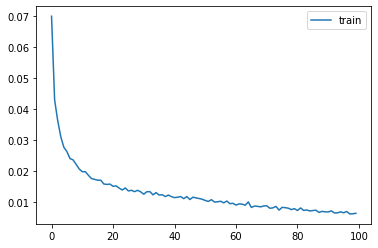

In [430]:
#Plotting Loss over Epochs
plt.plot(forecast_features.history.history['loss'], label='train')
plt.legend()
plt.show()

In [431]:
#Best loss and MAE
print(min(forecast_features.history.history['loss']))
print(min(forecast_features.history.history['mean_absolute_error']))

0.006253579353871194
0.055443406


In [432]:
#Evauating Model
print(forecast_features.evaluate(xte_fore, yte_fore))

94/94 [==============================] - 2s 24ms/step
[0.013316423453866168, 0.09424961358308792]


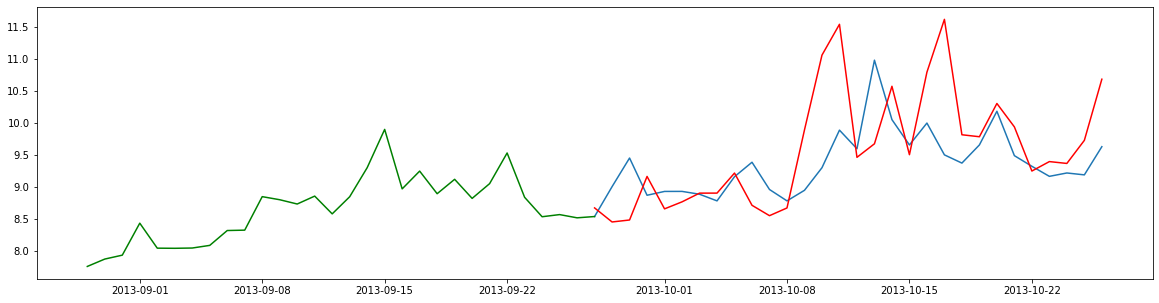

In [433]:
n_forecast = 10
days_forward = 3

forecast = forecast(forecast_features, scaled_featurestrain, 30, n_forecast, days_forward, n_features = 5)

forecast = np.array(forecast)[:,:,-1:]

projections = forecast_visualization(energytrain_df[['Avg.Dawn','Avg.Morning_Afternoon',
                                                    'Avg.Evening','Avg.Night', 'energy_sum']], 
                                     energytest_df[['Avg.Dawn','Avg.Morning_Afternoon',
                                                   'Avg.Evening','Avg.Night','energy_sum']],
                                     scaler_target, forecast, n_forecast, days_forward)

In [434]:
mae = mean_absolute_error(projections['energy_sum'][:30], projections['Prediction'][:30])
print('mean absolute error: {}'.format(mae))

mean absolute error: 0.545603564188161
